#  Análisis de Restaurantes en TripAdvisor: Segmentación, Sentimiento y Factores que Influyen en la Valoración

**Autora**: Silvia Montiel Sánchez  
**Máster**: MUBA – Universidad Pontificia Comillas  
**Dataset original**: TripAdvisor Restaurants Info for 31 Euro-Cities https://www.kaggle.com/datasets/damienbeneschi/krakow-ta-restaurans-data-raw/data


---

###  Objetivo del TFM

Este proyecto forma parte del Trabajo de Fin de Máster en Business Analytics. El objetivo es analizar un conjunto de datos reales de restaurantes de TripAdvisor con el fin de:

1. Identificar patrones ocultos en las valoraciones y opiniones de los usuarios.
2. Segmentar los restaurantes según características estructurales y semánticas.
3. Explorar qué factores pueden estar influyendo en los ratings asignados.

Para ello, se integra información textual (reseñas) con variables numéricas y categóricas (número de reseñas, tipo de cocina, ciudad, etc.), aplicando técnicas avanzadas de Procesamiento de Lenguaje Natural (NLP), reducción de dimensionalidad y clustering.

---

### Descripción del dataset

Se parte de una versión curada del dataset `TA_restaurants_curated.csv`, que contiene información estructurada y texto libre. Entre las variables disponibles se incluyen:

- **Name**: Nombre del restaurante.
- **City**: Ciudad donde se encuentra el restaurante.
- **Cuisine Style**: Tipo(s) de cocina que ofrece (por ejemplo, italiana, mediterránea, etc.).
- **Ranking**: Posición del restaurante en el ranking de su ciudad.
- **Rating**: Valoración media en TripAdvisor (escala de 1 a 5).
- **Price Range**: Rango de precios (por ejemplo, barato, medio, caro).
- **Number of Reviews**: Número total de reseñas que ha recibido.
- **Reviews**: Lista de las reseñas en texto realizadas por los clientes.
- **URL_TA**: Enlace al perfil del restaurante en TripAdvisor.
- **ID_TA**: Identificador único del restaurante en la plataforma.

---



##  Índice
1. Carga y exploración de datos
2. Preprocesamiento
3. Embeddings de reseñas
4. Análisis de variables estructurales
5. PCA y análisis de varianza
6. Clustering
7. Interpretación de resultados
8. Conclusiones

In [1]:
!pip install -U sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textblob import TextBlob
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import ast
import re
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.manifold import TSNE

##  1. Carga y exploración de los datos


In [3]:
df=pd.read_csv("TA_restaurants_curated.csv")

In [4]:
df

Unnamed: 0                          Name       City  \
0                0    Martine of Martine's Table  Amsterdam   
1                1           De Silveren Spiegel  Amsterdam   
2                2                       La Rive  Amsterdam   
3                3                      Vinkeles  Amsterdam   
4                4     Librije's Zusje Amsterdam  Amsterdam   
...            ...                           ...        ...   
125522        1662  Konrad Kaffee- & Cocktailbar     Zurich   
125523        1663     Blueberry American Bakery     Zurich   
125524        1664            Restaurant Bahnhof     Zurich   
125525        1665                    Yoyo Pizza     Zurich   
125526        1666                         dieci     Zurich   

                                            Cuisine Style  Ranking  Rating  \
0                         ['French', 'Dutch', 'European']      1.0     5.0   
1       ['Dutch', 'European', 'Vegetarian Friendly', '...      2.0     4.5   
2       ['Mediterranean', 'French', 'International', '...      3.0     4.5   
3       ['French', 'European', 'International', 'Conte...      4.0     5.0   
4       ['Dutch', 'European', 'International', 'Vegeta...      5.0     4.5   
...                                                   ...      ...     ...   
125522                                                NaN      NaN     NaN   
125523                                           ['Cafe']      NaN     NaN   
125524                                                NaN      NaN     NaN   
125525                                      ['Fast Food']      NaN     NaN   
125526     ['Italian', 'Pizza', 'Mediterranean', 'Diner']      NaN     NaN   

       Price Range  Number of Reviews  \
0         $$ - $$$              136.0   
1             $$$$              812.0   
2             $$$$              567.0   
3             $$$$              564.0   
4             $$$$              316.0   
...            ...                ...   
125522         NaN                NaN   
125523         NaN                NaN   
125524         NaN                NaN   
125525         NaN                NaN   
125526    $$ - $$$                NaN   

                                                  Reviews  \
0       [['Just like home', 'A Warm Welcome to Wintry ...   
1       [['Great food and staff', 'just perfect'], ['0...   
2       [['Satisfaction', 'Delicious old school restau...   
3       [['True five star dinner', 'A superb evening o...   
4       [['Best meal.... EVER', 'super food experience...   
...                                                   ...   
125522                                                NaN   
125523                                                NaN   
125524                                                NaN   
125525                                                NaN   
125526                                                NaN   

                                                   URL_TA      ID_TA  
0       /Restaurant_Review-g188590-d11752080-Reviews-M...  d11752080  
1       /Restaurant_Review-g188590-d693419-Reviews-De_...    d693419  
2       /Restaurant_Review-g188590-d696959-Reviews-La_...    d696959  
3       /Restaurant_Review-g188590-d1239229-Reviews-Vi...   d1239229  
4       /Restaurant_Review-g188590-d6864170-Reviews-Li...   d6864170  
...                                                   ...        ...  
125522  /Restaurant_Review-g188113-d13273526-Reviews-K...  d13273526  
125523  /Restaurant_Review-g188113-d13292844-Reviews-B...  d13292844  
125524  /Restaurant_Review-g188113-d13296092-Reviews-R...  d13296092  
125525  /Restaurant_Review-g188113-d13323362-Reviews-Y...  d13323362  
125526  /Restaurant_Review-g188113-d13349842-Reviews-D...  d13349842  

[125527 rows x 11 columns]

In [5]:
print(df.head())

   Unnamed: 0                        Name       City  \
0           0  Martine of Martine's Table  Amsterdam   
1           1         De Silveren Spiegel  Amsterdam   
2           2                     La Rive  Amsterdam   
3           3                    Vinkeles  Amsterdam   
4           4   Librije's Zusje Amsterdam  Amsterdam   

                                       Cuisine Style  Ranking  Rating  \
0                    ['French', 'Dutch', 'European']      1.0     5.0   
1  ['Dutch', 'European', 'Vegetarian Friendly', '...      2.0     4.5   
2  ['Mediterranean', 'French', 'International', '...      3.0     4.5   
3  ['French', 'European', 'International', 'Conte...      4.0     5.0   
4  ['Dutch', 'European', 'International', 'Vegeta...      5.0     4.5   

  Price Range  Number of Reviews  \
0    $$ - $$$              136.0   
1        $$$$              812.0   
2        $$$$              567.0   
3        $$$$              564.0   
4        $$$$              316.0   

       

In [6]:
# Contar el número de registros por ciudad y obtener las top 10
top_10_cities = df['City'].value_counts().head(10)


print("Top 10 ciudades por número de registros:")
print(top_10_cities)

Top 10 ciudades por número de registros:
City
London       18212
Paris        14874
Madrid        9543
Barcelona     8425
Berlin        7078
Milan         6687
Rome          5949
Prague        4859
Lisbon        3986
Vienna        3724
Name: count, dtype: int64


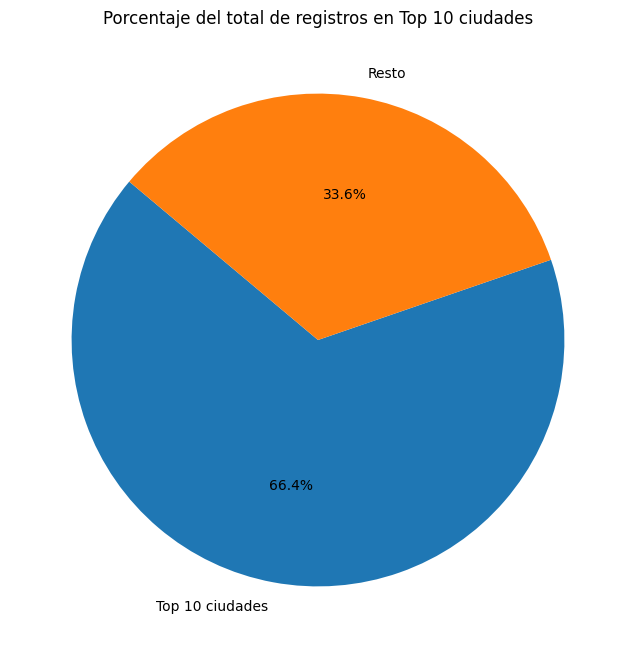

In [7]:

top_10_counts = df['City'].value_counts().head(10)


entries_top_10 = top_10_counts.sum()


total_entries = len(df)

# Calcular el porcentaje
percentage_top_10 = (entries_top_10 / total_entries) * 100


labels = ['Top 10 ciudades', 'Resto']
sizes = [entries_top_10, total_entries - entries_top_10]


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Porcentaje del total de registros en Top 10 ciudades')
plt.show()


Un gráfico circular muestra que aproximadamente el 66.4% de los datos provienen del Top 10 de ciudades, como Londres, París, Madrid o Barcelona, mientras que el 33.6% restante corresponde al resto.

El código asociado carga el dataset, identifica las 10 ciudades con más registros y filtra los datos, quedándose con 83,337 restaurantes. Este análisis permite enfocar el estudio en las ciudades con mayor representación, facilitando comparaciones y visualizaciones más relevantes.

In [8]:

top_10_cities = df.groupby("City")["Number of Reviews"].count().sort_values(ascending=False).head(10).index.tolist()
top_10_cities = df.groupby("City")["Number of Reviews"].count().sort_values(ascending=False).head(10).index.tolist()

# Filtrar el dataset por las top 10 ciudades
df_top_cities = df[df["City"].isin(top_10_cities)].copy()

# Mostrar resumen
print("Top 10 ciudades seleccionadas:", top_10_cities)
print("Número de registros en el dataset filtrado:", len(df_top_cities))


Top 10 ciudades seleccionadas: ['London', 'Paris', 'Madrid', 'Barcelona', 'Milan', 'Berlin', 'Rome', 'Prague', 'Lisbon', 'Vienna']
Número de registros en el dataset filtrado: 83337


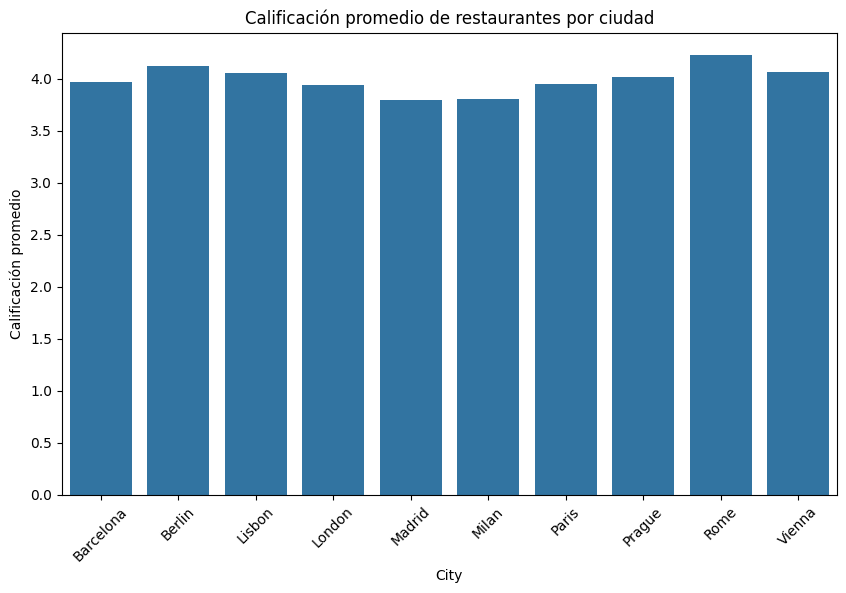

In [9]:
avg_rating_by_city = df_top_cities.groupby('City')['Rating'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_rating_by_city.index, y=avg_rating_by_city.values)
plt.title('Calificación promedio de restaurantes por ciudad')
plt.xticks(rotation=45)
plt.ylabel('Calificación promedio')
plt.show()

In [10]:
df_top_cities.head()


Unnamed: 0             Name       City  \
5372           0              Uma  Barcelona   
5373           1            Viana  Barcelona   
5374           2           Blavis  Barcelona   
5375           3    My Restaurant  Barcelona   
5376           4  Bodega Biarritz  Barcelona   

                                          Cuisine Style  Ranking  Rating  \
5372  ['International', 'Mediterranean', 'Fusion', '...      1.0     5.0   
5373  ['International', 'Mediterranean', 'Spanish', ...      2.0     5.0   
5374  ['Mediterranean', 'European', 'Spanish', 'Vege...      3.0     5.0   
5375  ['Mediterranean', 'European', 'Spanish', 'Vege...      4.0     5.0   
5376  ['Mediterranean', 'Spanish', 'Wine Bar', 'Euro...      5.0     5.0   

     Price Range  Number of Reviews  \
5372        $$$$              792.0   
5373    $$ - $$$             2707.0   
5374    $$ - $$$              643.0   
5375    $$ - $$$              159.0   
5376    $$ - $$$             1078.0   

                                                Reviews  \
5372  [['Perfect atmosphere and location', 'Perfecti...   
5373  [['Wow! Best ever!', 'Small menu-- GET A RESER...   
5374  [['The whole package', 'Incredible Service and...   
5375  [['Fantastic evening!!', 'Perfect meal'], ['01...   
5376  [['Deserves its reputation!', 'THESE ARE THE T...   

                                                 URL_TA      ID_TA  
5372  /Restaurant_Review-g187497-d8003030-Reviews-Um...   d8003030  
5373  /Restaurant_Review-g187497-d8531409-Reviews-Vi...   d8531409  
5374  /Restaurant_Review-g187497-d3353672-Reviews-Bl...   d3353672  
5375  /Restaurant_Review-g187497-d12643500-Reviews-M...  d12643500  
5376  /Restaurant_Review-g187497-d11906544-Reviews-B...  d11906544

In [11]:
print(df_top_cities['Price Range'].unique())


['$$$$' '$$ - $$$' '$' nan]


In [12]:

price_mapping = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df_top_cities['Price Range Numeric'] = df_top_cities['Price Range'].map(price_mapping).fillna(0)


In [13]:
df_top_cities

Unnamed: 0                    Name       City  \
5372             0                     Uma  Barcelona   
5373             1                   Viana  Barcelona   
5374             2                  Blavis  Barcelona   
5375             3           My Restaurant  Barcelona   
5376             4         Bodega Biarritz  Barcelona   
...            ...                     ...        ...   
121503        3719  restaurant you, Vienne     Vienna   
121504        3720       Kartonage Kitchen     Vienna   
121505        3721                    Fino     Vienna   
121506        3722       Cafe Zeitgenossin     Vienna   
121507        3723               El Gaucho     Vienna   

                                            Cuisine Style  Ranking  Rating  \
5372    ['International', 'Mediterranean', 'Fusion', '...      1.0     5.0   
5373    ['International', 'Mediterranean', 'Spanish', ...      2.0     5.0   
5374    ['Mediterranean', 'European', 'Spanish', 'Vege...      3.0     5.0   
5375    ['Mediterranean', 'European', 'Spanish', 'Vege...      4.0     5.0   
5376    ['Mediterranean', 'Spanish', 'Wine Bar', 'Euro...      5.0     5.0   
...                                                   ...      ...     ...   
121503                 ['French', 'Austrian', 'European']      NaN     NaN   
121504  ['Austrian', 'International', 'European', 'Fus...      NaN     NaN   
121505                 ['German', 'Austrian', 'European']      NaN     NaN   
121506                  ['Cafe', 'Contemporary', 'Diner']      NaN     NaN   
121507                                                NaN      NaN     NaN   

       Price Range  Number of Reviews  \
5372          $$$$              792.0   
5373      $$ - $$$             2707.0   
5374      $$ - $$$              643.0   
5375      $$ - $$$              159.0   
5376      $$ - $$$             1078.0   
...            ...                ...   
121503         NaN                NaN   
121504           $                NaN   
121505         NaN                NaN   
121506           $                NaN   
121507         NaN                NaN   

                                                  Reviews  \
5372    [['Perfect atmosphere and location', 'Perfecti...   
5373    [['Wow! Best ever!', 'Small menu-- GET A RESER...   
5374    [['The whole package', 'Incredible Service and...   
5375    [['Fantastic evening!!', 'Perfect meal'], ['01...   
5376    [['Deserves its reputation!', 'THESE ARE THE T...   
...                                                   ...   
121503                                                NaN   
121504                                                NaN   
121505                                                NaN   
121506                                                NaN   
121507                                                NaN   

                                                   URL_TA      ID_TA  \
5372    /Restaurant_Review-g187497-d8003030-Reviews-Um...   d8003030   
5373    /Restaurant_Review-g187497-d8531409-Reviews-Vi...   d8531409   
5374    /Restaurant_Review-g187497-d3353672-Reviews-Bl...   d3353672   
5375    /Restaurant_Review-g187497-d12643500-Reviews-M...  d12643500   
5376    /Restaurant_Review-g187497-d11906544-Reviews-B...  d11906544   
...                                                   ...        ...   
121503  /Restaurant_Review-g190454-d13331692-Reviews-R...  d13331692   
121504  /Restaurant_Review-g190454-d13337747-Reviews-K...  d13337747   
121505  /Restaurant_Review-g190454-d13341715-Reviews-F...  d13341715   
121506  /Restaurant_Review-g190454-d13343747-Reviews-C...  d13343747   
121507  /Restaurant_Review-g190454-d13359780-Reviews-E...  d13359780   

        Price Range Numeric  
5372                    3.0  
5373                    2.0  
5374                    2.0  
5375                    2.0  
5376                    2.0  
...                     ...  
121503                  0.0  
121504                  1.0  
121505                  0

In [14]:
# Rellenar valores nulos en 'Reviews' con texto vacío
df_top_cities['Text'] = df_top_cities['Reviews'].fillna('')

# Calcular polaridad del texto
df_top_cities['Polarity'] = df_top_cities['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Calcular longitud del texto
df_top_cities['Text Length'] = df_top_cities['Text'].apply(len)


In [15]:
import ast

def identify_dietary_specialties_list(cuisine_list):
    if not cuisine_list or not isinstance(cuisine_list, list):
        return []

    diet_terms = {
        'Vegetarian Friendly': 'Vegetarian',
        'Vegan Options': 'Vegan',
        'Gluten Free Options': 'Gluten Free',
        'Halal': 'Halal',
        'Kosher': 'Kosher',
        'Healthy': 'Healthy'
    }
    return [diet_terms[term] for term in cuisine_list if term in diet_terms]

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x) if pd.notnull(x) else []
    except (ValueError, SyntaxError):
        return []

df_top_cities['Cuisine Style List'] = df_top_cities['Cuisine Style'].apply(safe_literal_eval)
df_top_cities['Dietary Specialties'] = df_top_cities['Cuisine Style List'].apply(identify_dietary_specialties_list)

print(df_top_cities[['Cuisine Style', 'Cuisine Style List', 'Dietary Specialties']].head(20))


                                          Cuisine Style  \
5372  ['International', 'Mediterranean', 'Fusion', '...   
5373  ['International', 'Mediterranean', 'Spanish', ...   
5374  ['Mediterranean', 'European', 'Spanish', 'Vege...   
5375  ['Mediterranean', 'European', 'Spanish', 'Vege...   
5376  ['Mediterranean', 'Spanish', 'Wine Bar', 'Euro...   
5377  ['Mediterranean', 'Spanish', 'European', 'Fusi...   
5378             ['Mediterranean', 'Fusion', 'Spanish']   
5379  ['African', 'International', 'Asian', 'Middle ...   
5380  ['Mexican', 'Mediterranean', 'Delicatessen', '...   
5381  ['Pub', 'Latin', 'Bar', 'Street Food', 'Vegeta...   
5382  ['Mediterranean', 'Spanish', 'Vegetarian Frien...   
5383                 ['Italian', 'Gluten Free Options']   
5384  ['Fusion', 'Mediterranean', 'European', 'Spani...   
5385  ['Mediterranean', 'European', 'Spanish', 'Inte...   
5386   ['American', 'Fast Food', 'Vegetarian Friendly']   
5387                 ['Spanish', 'Gluten Free Options'] 

In [16]:
df_top_cities

Unnamed: 0                    Name       City  \
5372             0                     Uma  Barcelona   
5373             1                   Viana  Barcelona   
5374             2                  Blavis  Barcelona   
5375             3           My Restaurant  Barcelona   
5376             4         Bodega Biarritz  Barcelona   
...            ...                     ...        ...   
121503        3719  restaurant you, Vienne     Vienna   
121504        3720       Kartonage Kitchen     Vienna   
121505        3721                    Fino     Vienna   
121506        3722       Cafe Zeitgenossin     Vienna   
121507        3723               El Gaucho     Vienna   

                                            Cuisine Style  Ranking  Rating  \
5372    ['International', 'Mediterranean', 'Fusion', '...      1.0     5.0   
5373    ['International', 'Mediterranean', 'Spanish', ...      2.0     5.0   
5374    ['Mediterranean', 'European', 'Spanish', 'Vege...      3.0     5.0   
5375    ['Mediterranean', 'European', 'Spanish', 'Vege...      4.0     5.0   
5376    ['Mediterranean', 'Spanish', 'Wine Bar', 'Euro...      5.0     5.0   
...                                                   ...      ...     ...   
121503                 ['French', 'Austrian', 'European']      NaN     NaN   
121504  ['Austrian', 'International', 'European', 'Fus...      NaN     NaN   
121505                 ['German', 'Austrian', 'European']      NaN     NaN   
121506                  ['Cafe', 'Contemporary', 'Diner']      NaN     NaN   
121507                                                NaN      NaN     NaN   

       Price Range  Number of Reviews  \
5372          $$$$              792.0   
5373      $$ - $$$             2707.0   
5374      $$ - $$$              643.0   
5375      $$ - $$$              159.0   
5376      $$ - $$$             1078.0   
...            ...                ...   
121503         NaN                NaN   
121504           $                NaN   
121505         NaN                NaN   
121506           $                NaN   
121507         NaN                NaN   

                                                  Reviews  \
5372    [['Perfect atmosphere and location', 'Perfecti...   
5373    [['Wow! Best ever!', 'Small menu-- GET A RESER...   
5374    [['The whole package', 'Incredible Service and...   
5375    [['Fantastic evening!!', 'Perfect meal'], ['01...   
5376    [['Deserves its reputation!', 'THESE ARE THE T...   
...                                                   ...   
121503                                                NaN   
121504                                                NaN   
121505                                                NaN   
121506                                                NaN   
121507                                                NaN   

                                                   URL_TA      ID_TA  \
5372    /Restaurant_Review-g187497-d8003030-Reviews-Um...   d8003030   
5373    /Restaurant_Review-g187497-d8531409-Reviews-Vi...   d8531409   
5374    /Restaurant_Review-g187497-d3353672-Reviews-Bl...   d3353672   
5375    /Restaurant_Review-g187497-d12643500-Reviews-M...  d12643500   
5376    /Restaurant_Review-g187497-d11906544-Reviews-B...  d11906544   
...                                                   ...        ...   
121503  /Restaurant_Review-g190454-d13331692-Reviews-R...  d13331692   
121504  /Restaurant_Review-g190454-d13337747-Reviews-K...  d13337747   
121505  /Restaurant_Review-g190454-d13341715-Reviews-F...  d13341715   
121506  /Restaurant_Review-g190454-d13343747-Reviews-C...  d13343747   
121507  /Restaurant_Review-g190454-d13359780-Reviews-E...  d13359780   

        Price Range Numeric  \
5372                    3.0   
5373                    2.0   
5374                    2.0   
5375                    2.0   
5376                    2.0   
...                     ...   
121503                  0.0   
121504                  1.0   
121505          

In [17]:
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

df_top_cities['Reviews List'] = df_top_cities['Reviews'].apply(lambda x: safe_literal_eval(x) if pd.notnull(x) else [])

def extract_review_texts(x):
    return x[0] if isinstance(x, list) and len(x) > 0 else [None, None]

def extract_review_dates(x):
    return x[1] if isinstance(x, list) and len(x) > 1 else [None, None]

df_top_cities[['Review Text 1', 'Review Text 2']] = pd.DataFrame(df_top_cities['Reviews List'].apply(extract_review_texts).tolist(), index=df_top_cities.index)
df_top_cities[['Review Date 1', 'Review Date 2']] = pd.DataFrame(df_top_cities['Reviews List'].apply(extract_review_dates).tolist(), index=df_top_cities.index)


In [18]:
df_top_cities

Unnamed: 0                    Name       City  \
5372             0                     Uma  Barcelona   
5373             1                   Viana  Barcelona   
5374             2                  Blavis  Barcelona   
5375             3           My Restaurant  Barcelona   
5376             4         Bodega Biarritz  Barcelona   
...            ...                     ...        ...   
121503        3719  restaurant you, Vienne     Vienna   
121504        3720       Kartonage Kitchen     Vienna   
121505        3721                    Fino     Vienna   
121506        3722       Cafe Zeitgenossin     Vienna   
121507        3723               El Gaucho     Vienna   

                                            Cuisine Style  Ranking  Rating  \
5372    ['International', 'Mediterranean', 'Fusion', '...      1.0     5.0   
5373    ['International', 'Mediterranean', 'Spanish', ...      2.0     5.0   
5374    ['Mediterranean', 'European', 'Spanish', 'Vege...      3.0     5.0   
5375    ['Mediterranean', 'European', 'Spanish', 'Vege...      4.0     5.0   
5376    ['Mediterranean', 'Spanish', 'Wine Bar', 'Euro...      5.0     5.0   
...                                                   ...      ...     ...   
121503                 ['French', 'Austrian', 'European']      NaN     NaN   
121504  ['Austrian', 'International', 'European', 'Fus...      NaN     NaN   
121505                 ['German', 'Austrian', 'European']      NaN     NaN   
121506                  ['Cafe', 'Contemporary', 'Diner']      NaN     NaN   
121507                                                NaN      NaN     NaN   

       Price Range  Number of Reviews  \
5372          $$$$              792.0   
5373      $$ - $$$             2707.0   
5374      $$ - $$$              643.0   
5375      $$ - $$$              159.0   
5376      $$ - $$$             1078.0   
...            ...                ...   
121503         NaN                NaN   
121504           $                NaN   
121505         NaN                NaN   
121506           $                NaN   
121507         NaN                NaN   

                                                  Reviews  \
5372    [['Perfect atmosphere and location', 'Perfecti...   
5373    [['Wow! Best ever!', 'Small menu-- GET A RESER...   
5374    [['The whole package', 'Incredible Service and...   
5375    [['Fantastic evening!!', 'Perfect meal'], ['01...   
5376    [['Deserves its reputation!', 'THESE ARE THE T...   
...                                                   ...   
121503                                                NaN   
121504                                                NaN   
121505                                                NaN   
121506                                                NaN   
121507                                                NaN   

                                                   URL_TA  ...  \
5372    /Restaurant_Review-g187497-d8003030-Reviews-Um...  ...   
5373    /Restaurant_Review-g187497-d8531409-Reviews-Vi...  ...   
5374    /Restaurant_Review-g187497-d3353672-Reviews-Bl...  ...   
5375    /Restaurant_Review-g187497-d12643500-Reviews-M...  ...   
5376    /Restaurant_Review-g187497-d11906544-Reviews-B...  ...   
...                                                   ...  ...   
121503  /Restaurant_Review-g190454-d13331692-Reviews-R...  ...   
121504  /Restaurant_Review-g190454-d13337747-Reviews-K...  ...   
121505  /Restaurant_Review-g190454-d13341715-Reviews-F...  ...   
121506  /Restaurant_Review-g190454-d13343747-Reviews-C...  ...   
121507  /Restaurant_Review-g190454-d13359780-Reviews-E...  ...   

                                                     Text  Polarity  \
5372    [['Perfect atmosphere and location', 'Perfecti...  1.000000   
5373    [['Wow! Best ever!', 'Small menu-- GET A RESER...  0.291667   
5374    [['The whole package', 'Incredible Service and...  0.600000   
5375    [['Fantastic evening!!', 'Perfect meal'], ['01...  0.812500   
5376    [['D

In [19]:
df_top_cities["Number of Reviews"] = pd.to_numeric(df_top_cities["Number of Reviews"], errors='coerce')


In [20]:
df_top_cities.describe()

Unnamed: 0       Ranking        Rating  Number of Reviews  \
count  83337.000000  76943.000000  76964.000000       71973.000000   
mean    5390.462004   4956.875557      3.971006         135.792103   
std     4301.629273   3921.425098      0.684840         330.575736   
min        0.000000      1.000000     -1.000000           2.000000   
25%     2083.000000   1925.000000      3.500000          10.000000   
50%     4244.000000   3917.000000      4.000000          35.000000   
75%     7554.000000   6949.000000      4.500000         128.000000   
max    18211.000000  16444.000000      5.000000       13862.000000   

       Price Range Numeric      Polarity   Text Length  
count         83337.000000  83337.000000  83337.000000  
mean              1.114715      0.327541     63.172744  
std               0.964644      0.375047     37.626789  
min               0.000000     -1.000000      0.000000  
25%               0.000000      0.000000     31.000000  
50%               1.000000      0.328125     74.000000  
75%               2.000000      0.625000     92.000000  
max               3.000000      1.000000    132.000000

In [21]:
print(df_top_cities.isnull().sum())

Unnamed: 0                 0
Name                       0
City                       0
Cuisine Style          20441
Ranking                 6394
Rating                  6373
Price Range            31728
Number of Reviews      11364
Reviews                 6369
URL_TA                     0
ID_TA                      0
Price Range Numeric        0
Text                       0
Polarity                   0
Text Length                0
Cuisine Style List         0
Dietary Specialties        0
Reviews List               0
Review Text 1          20227
Review Text 2          29130
Review Date 1          20227
Review Date 2          29130
dtype: int64


In [22]:
print("Tamaño del dataset después de la limpieza:", df_top_cities.shape)


Tamaño del dataset después de la limpieza: (83337, 22)


In [23]:
print(df_top_cities.info())

<class 'pandas.core.frame.DataFrame'>
Index: 83337 entries, 5372 to 121507
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           83337 non-null  int64  
 1   Name                 83337 non-null  object 
 2   City                 83337 non-null  object 
 3   Cuisine Style        62896 non-null  object 
 4   Ranking              76943 non-null  float64
 5   Rating               76964 non-null  float64
 6   Price Range          51609 non-null  object 
 7   Number of Reviews    71973 non-null  float64
 8   Reviews              76968 non-null  object 
 9   URL_TA               83337 non-null  object 
 10  ID_TA                83337 non-null  object 
 11  Price Range Numeric  83337 non-null  float64
 12  Text                 83337 non-null  object 
 13  Polarity             83337 non-null  float64
 14  Text Length          83337 non-null  int64  
 15  Cuisine Style List   83337 non-null  

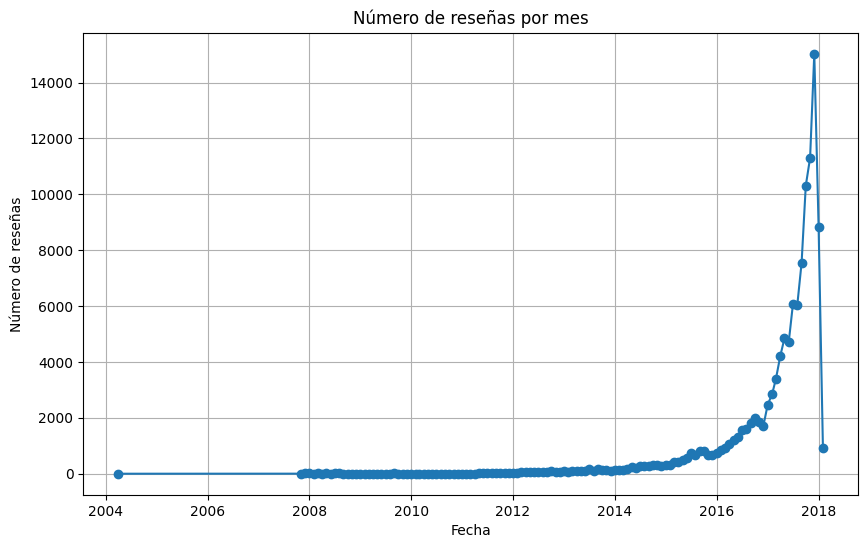

In [24]:
# Crear DataFrame expandido (comentario-fecha)
df_reviews = pd.concat([
    df_top_cities[['City', 'Name', 'Review Date 1']].rename(columns={'Review Date 1': 'Date'}),
    df_top_cities[['City', 'Name', 'Review Date 2']].rename(columns={'Review Date 2': 'Date'})
], ignore_index=True)

# Convertir Date a formato datetime
df_reviews['Date'] = pd.to_datetime(df_reviews['Date'], errors='coerce')

# Crear columna 'fdate' (mes)
df_reviews['fdate'] = df_reviews['Date'].dt.to_period('M').dt.to_timestamp()

# Contar número de reseñas por mes
df_reviews_counts = df_reviews.groupby('fdate').size().reset_index(name='n')

plt.figure(figsize=(10,6))
plt.plot(df_reviews_counts['fdate'], df_reviews_counts['n'], marker='o')
plt.title('Número de reseñas por mes')
plt.xlabel('Fecha')
plt.ylabel('Número de reseñas')
plt.grid()
plt.show()


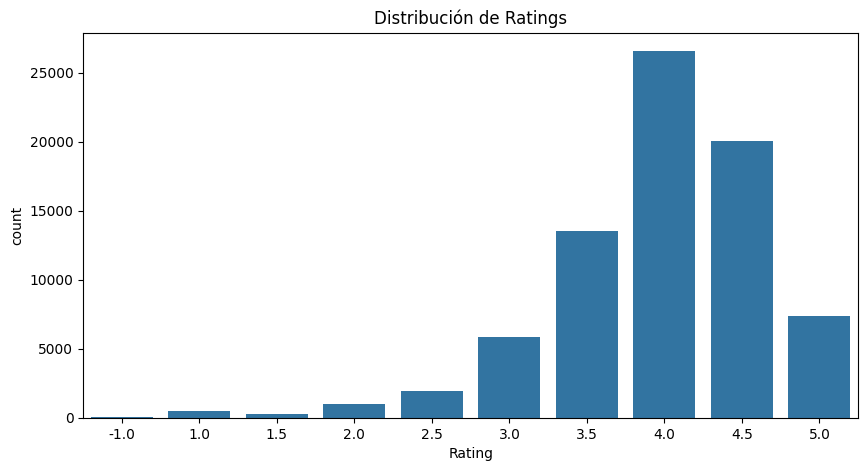

In [25]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Rating', data=df_top_cities)
plt.title('Distribución de Ratings')
plt.show()

La gráfica muestra la **distribución de los Ratings** en el conjunto de datos de los restaurantes analizados. En este histograma se observa que la mayoría de los restaurantes tienen una calificación que oscila entre **3.5 y 4.5**, lo que indica que la gran parte de los establecimientos reciben calificaciones favorables por parte de los usuarios. También se percibe un pico notable en el rango de calificaciones alrededor de 4.0, lo que sugiere que muchos restaurantes tienden a recibir una puntuación superior a la media.

Sin embargo, existen algunas calificaciones más bajas, aunque en menor cantidad, lo que indica que hay restaurantes con valoraciones más críticas. Esta visualización es clave para entender cómo se distribuyen las calificaciones generales y podría usarse como base para análisis más profundos, por ejemplo, para correlacionar ratings con otras variables como el tipo de cocina, la ciudad o el rango de precios. Esta distribución puede ayudar a identificar patrones de calidad y satisfacción general en el mercado de los restaurantes analizados.




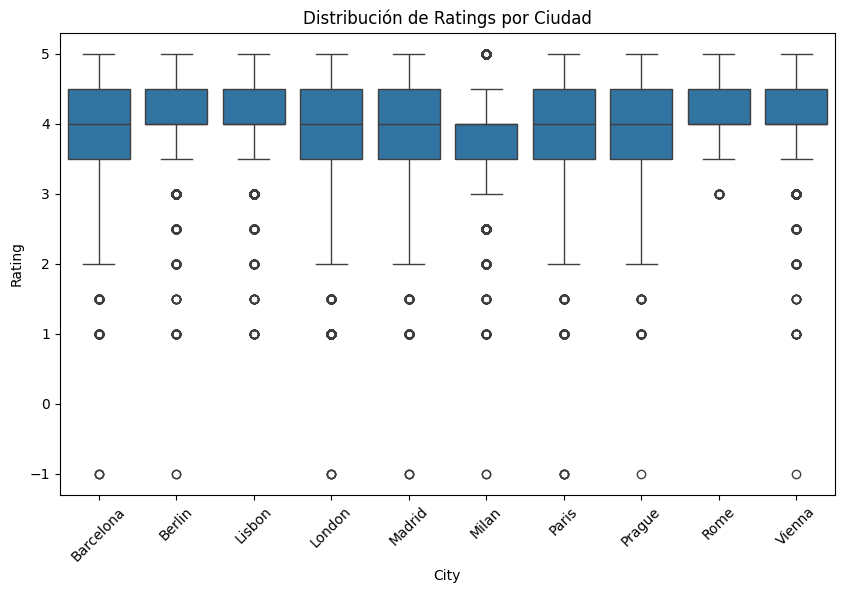

In [26]:
# Distribución de ratings por ciudad
plt.figure(figsize=(10, 6))
sns.boxplot(x='City', y='Rating', data=df_top_cities)
plt.xticks(rotation=45)
plt.title('Distribución de Ratings por Ciudad')
plt.show()


La gráfica "Distribución de Ratings por Ciudad" muestra, a través de un boxplot, cómo se reparten las calificaciones de los restaurantes en las principales ciudades analizadas. Cada caja refleja dónde se concentra la mayoría de los valores, y la línea en el centro marca la mediana. También se muestran los extremos y algunos valores atípicos.

En general, casi todas las ciudades comparten una mediana cercana a 4, pero se notan diferencias en la dispersión de los ratings y en la cantidad de puntuaciones atípicas. Esto sugiere que, aunque las valoraciones suelen ser buenas en promedio, hay ciudades donde la percepción de la calidad es más variada que en otras.

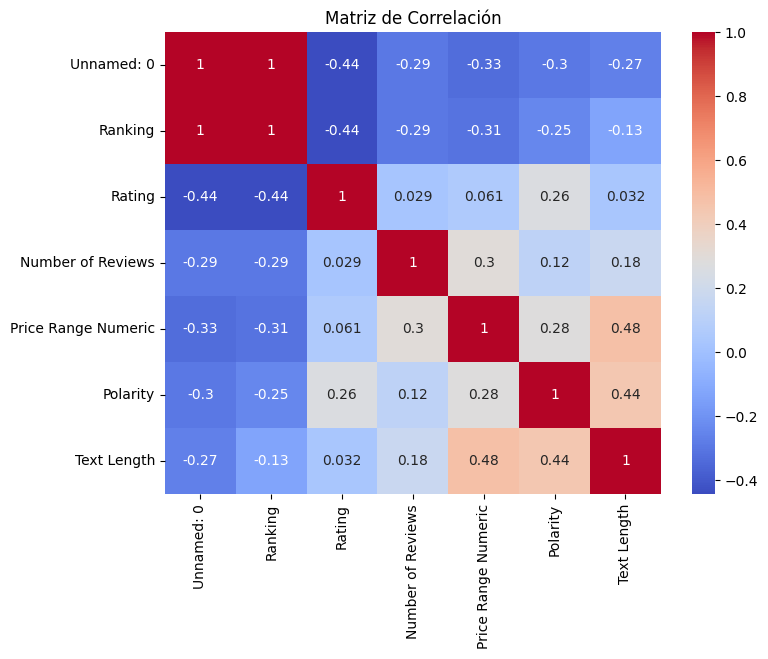

In [27]:
# Crear lista de columnas numéricas
numeric_cols = df_top_cities.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(8, 6))
sns.heatmap(df_top_cities[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()



La **"Matriz de Correlación"** representa las correlaciones entre las variables numéricas del dataset, visualizadas a través de un mapa de calor (heatmap). Cada celda muestra la correlación entre dos variables, donde un valor cercano a 1 indica una alta correlación positiva, un valor cercano a -1 indica una alta correlación negativa y un valor cercano a 0 indica poca o ninguna correlación. Se observa, por ejemplo, que la longitud del texto (`Text Length`) tiene una correlación moderada con la polaridad del comentario (`Polarity`), lo que podría reflejar que textos más largos tienden a expresar sentimient


In [28]:

def limpiar_texto(texto):
    if pd.isnull(texto):
        return ""
    texto = re.sub(r'<br\s*/?>', ' ', texto)
    texto = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = texto.lower()
    return texto.strip()

In [29]:
#  Crear la columna 'Clean Comment'
df_top_cities['Clean Comment'] = df_top_cities['Review Text 1'].apply(limpiar_texto)

In [30]:
# Vectorización con stopwords en inglés
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_top_cities['Clean Comment'].dropna())

In [31]:
# Procesar resultados
word_freq = X.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()
freq_dict = dict(zip(vocab, word_freq))

In [32]:
top_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 palabras más frecuentes:")
for word, freq in top_words:
    print(f"{word}: {freq}")


Top 10 palabras más frecuentes:
food: 10373
good: 9560
great: 8619
nice: 4572
place: 4024
service: 3473
restaurant: 2903
best: 2670
excellent: 2562
lunch: 2040


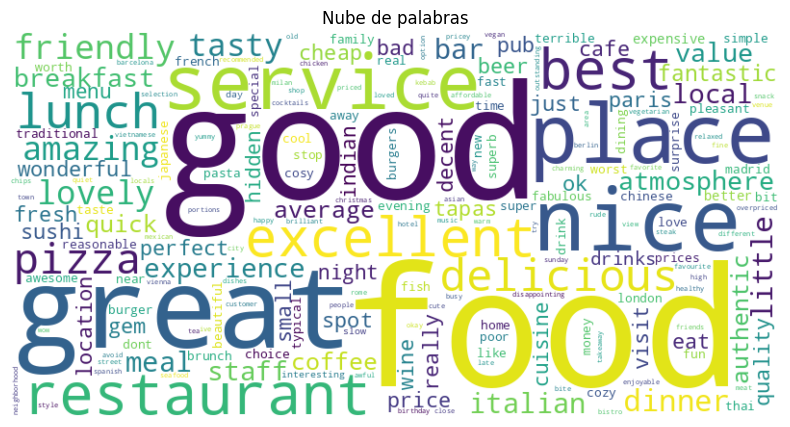

In [33]:
# Crear la WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras')
plt.show()


In [34]:
# Crear una nueva columna para el sentimiento
def get_sentiment(text):
    if pd.isnull(text) or not isinstance(text, str):
        return None
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

# Aplicar a tus comentarios
df_top_cities['Sentiment'] = df_top_cities['Clean Comment'].apply(get_sentiment)

# Mostrar resultados
print(df_top_cities[['Clean Comment', 'Sentiment']].head())


                        Clean Comment  Sentiment
5372  perfect atmosphere and location       1.00
5373                    wow best ever       0.55
5374                the whole package       0.20
5375                fantastic evening       0.40
5376          deserves its reputation       0.00


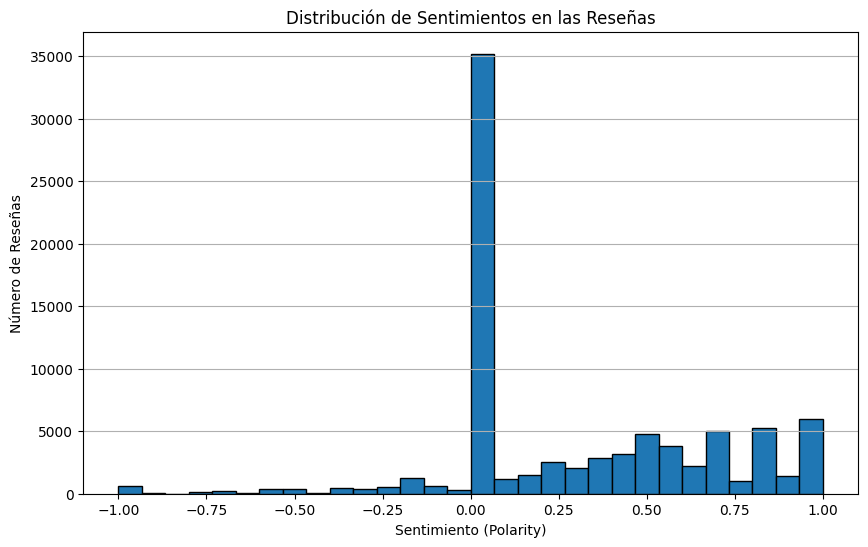

In [35]:
plt.figure(figsize=(10,6))
plt.hist(df_top_cities['Sentiment'].dropna(), bins=30, edgecolor='black')
plt.title('Distribución de Sentimientos en las Reseñas')
plt.xlabel('Sentimiento (Polarity)')
plt.ylabel('Número de Reseñas')
plt.grid(axis='y')
plt.show()


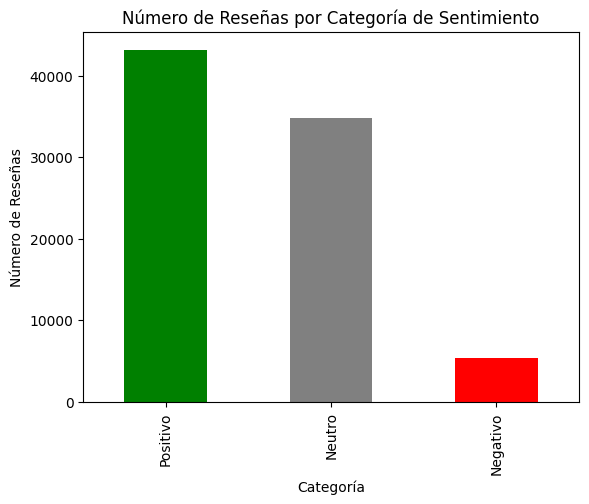

In [36]:
# Crear una columna categórica
def categorize_sentiment(score):
    if score > 0:
        return 'Positivo'
    elif score < 0:
        return 'Negativo'
    else:
        return 'Neutro'

df_top_cities['Sentiment Category'] = df_top_cities['Sentiment'].apply(categorize_sentiment)

sentiment_counts = df_top_cities['Sentiment Category'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Número de Reseñas por Categoría de Sentimiento')
plt.xlabel('Categoría')
plt.ylabel('Número de Reseñas')
plt.show()


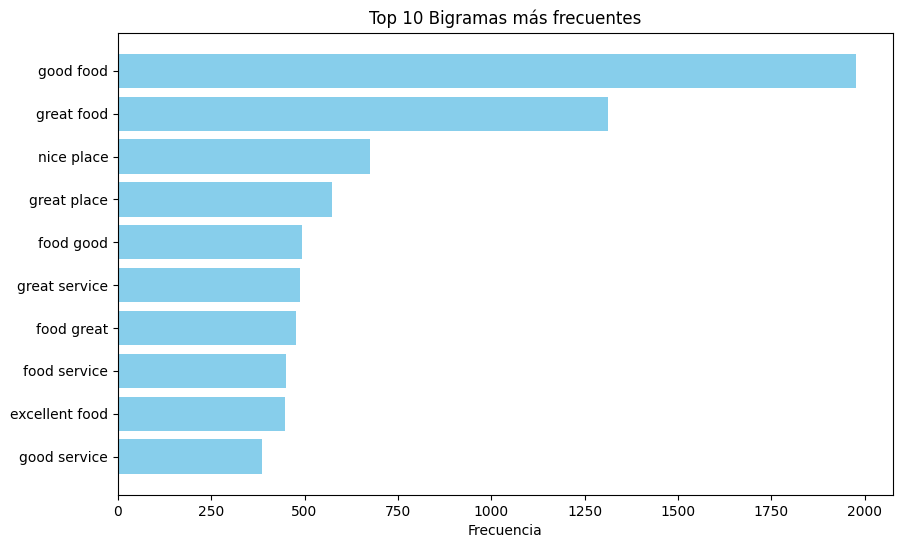

In [37]:

# Vectorizar los bigramas
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X_bigram = bigram_vectorizer.fit_transform(df_top_cities['Clean Comment'].dropna())
bigram_freq = X_bigram.toarray().sum(axis=0)
bigram_vocab = bigram_vectorizer.get_feature_names_out()
bigram_freq_dict = dict(zip(bigram_vocab, bigram_freq))

bigram_df = pd.DataFrame(list(bigram_freq_dict.items()), columns=['Bigram', 'Frequency'])
bigram_df = bigram_df.sort_values(by='Frequency', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(bigram_df['Bigram'], bigram_df['Frequency'], color='skyblue')
plt.xlabel('Frecuencia')
plt.title('Top 10 Bigramas más frecuentes')
plt.gca().invert_yaxis()
plt.show()


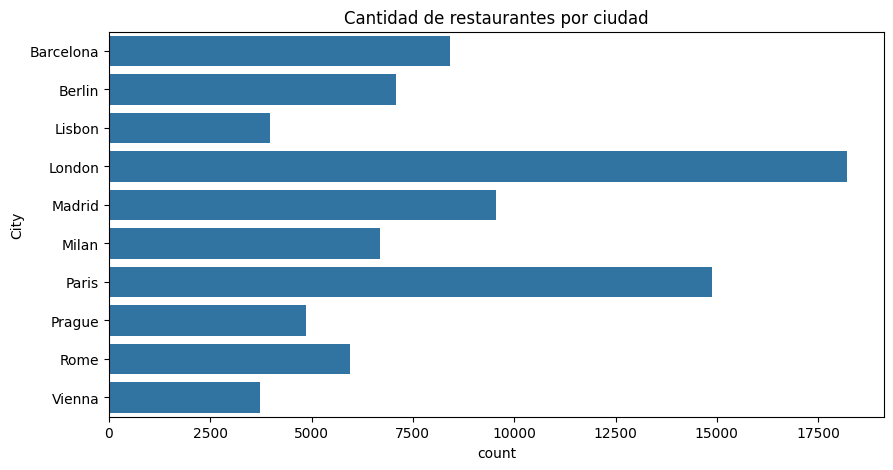

In [38]:
# Distribución por City
plt.figure(figsize=(10, 5))
sns.countplot(y='City', data=df_top_cities)
plt.title('Cantidad de restaurantes por ciudad')
plt.show()

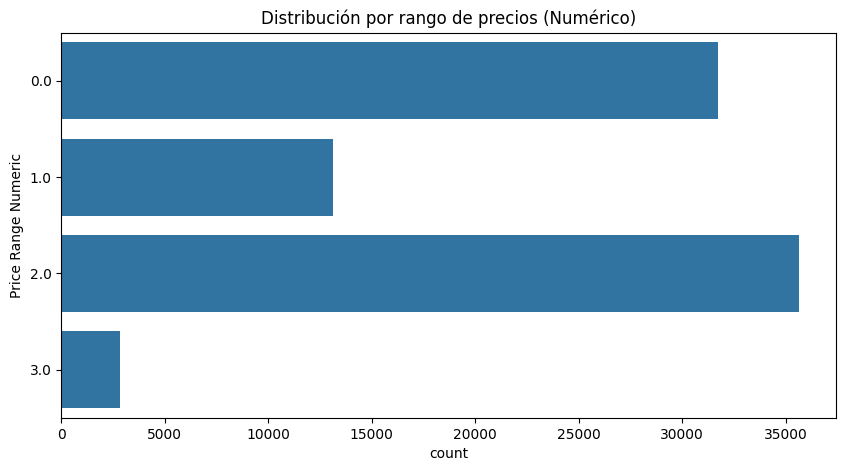

In [39]:
plt.figure(figsize=(10, 5))
sns.countplot(y='Price Range Numeric', data=df_top_cities)
plt.title('Distribución por rango de precios (Numérico)')
plt.show()


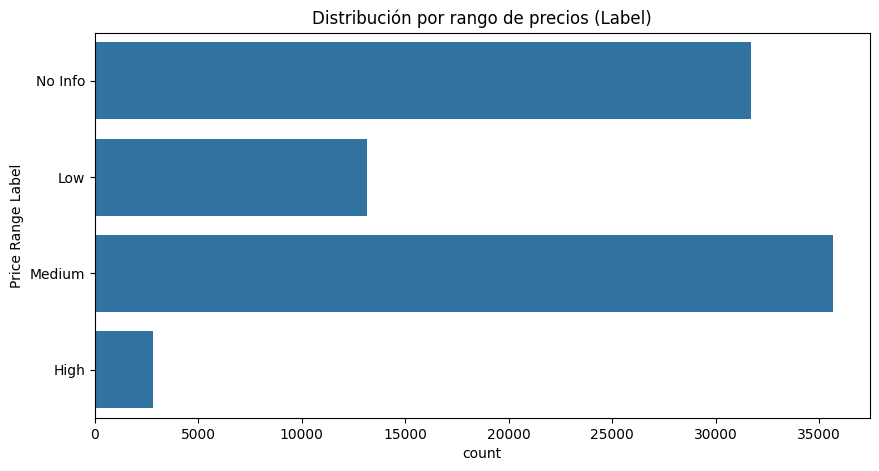

In [40]:
# Crear etiquetas legibles
label_mapping = {0: 'No Info', 1: 'Low', 2: 'Medium', 3: 'High'}
df_top_cities['Price Range Label'] = df_top_cities['Price Range Numeric'].map(label_mapping)

plt.figure(figsize=(10, 5))
sns.countplot(y='Price Range Label', data=df_top_cities, order=['No Info', 'Low', 'Medium', 'High'])
plt.title('Distribución por rango de precios (Label)')
plt.show()


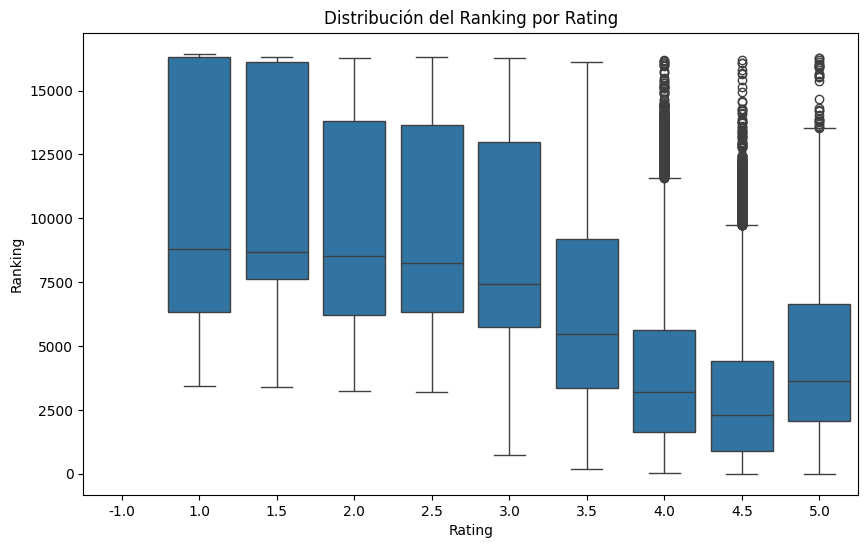

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='Ranking', data=df_top_cities)
plt.title('Distribución del Ranking por Rating')
plt.show()


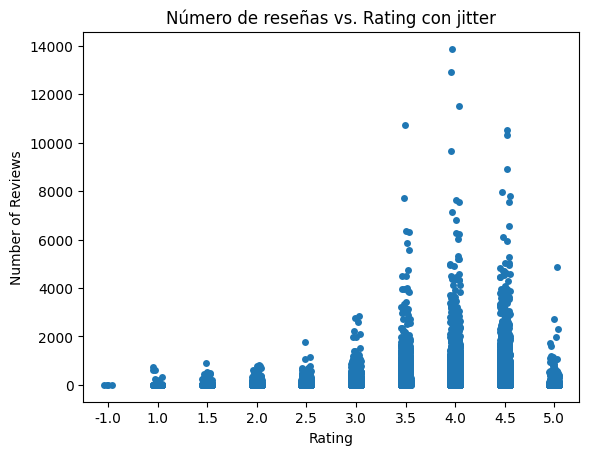

In [42]:
sns.stripplot(x='Rating', y='Number of Reviews', data=df_top_cities, jitter=True)
plt.title('Número de reseñas vs. Rating con jitter')
plt.show()


In [43]:
# Selección de columnas numéricas relevantes y eliminación de NaN
X = df_top_cities[['Ranking', 'Rating', 'Number of Reviews']].dropna()
df_clean = df_top_cities.loc[X.index].copy()

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


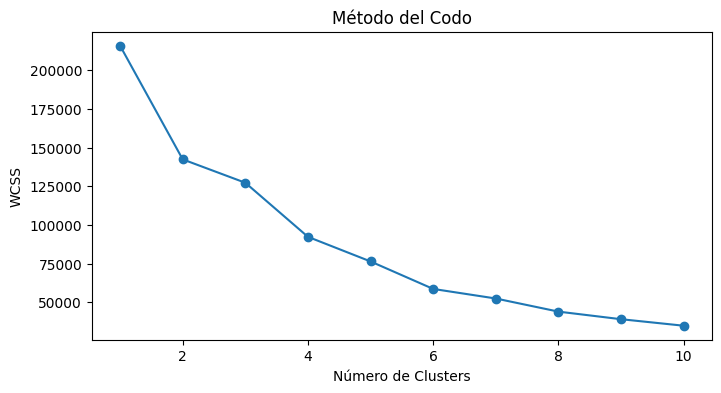

In [44]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()


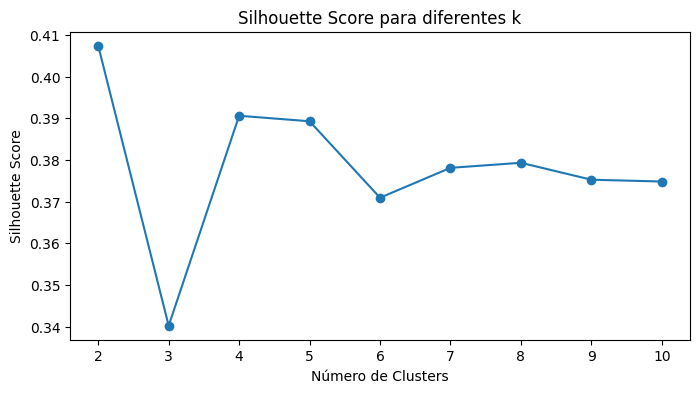

In [45]:

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score para diferentes k')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [47]:
# Definir columnas numéricas relevantes
numeric_columns = ['Ranking', 'Rating', 'Number of Reviews']

# Eliminar filas con NaN
df_top_cities = df_top_cities.dropna(subset=numeric_columns)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_top_cities[numeric_columns])

# Aplicar KMeans con el número óptimo de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
df_top_cities['Cluster'] = kmeans.fit_predict(X_scaled)

#  Crear copia limpia para análisis
df_clean = df_top_cities.copy()

#  Analizar promedios por cluster
cluster_summary = df_clean.groupby('Cluster')[['Ranking', 'Rating', 'Number of Reviews']].mean()
print(cluster_summary)

#  Distribución de ciudades por cluster
print(df_clean.groupby('Cluster')['City'].value_counts(normalize=True).unstack().fillna(0))


/tmp/ipython-input-47-2097998663.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_cities['Cluster'] = kmeans.fit_predict(X_scaled)


              Ranking    Rating  Number of Reviews
Cluster                                           
0        10140.386795  4.066693          20.873207
1         2645.033021  4.234728         120.181503
2         8105.903058  3.041184          62.790756
3          717.110064  4.097430        1423.763169
City     Barcelona    Berlin    Lisbon    London    Madrid     Milan  \
Cluster                                                                
0         0.014167  0.000535  0.000000  0.568832  0.017999  0.000000   
1         0.112961  0.106091  0.068137  0.126498  0.113772  0.093950   
2         0.130947  0.071439  0.023218  0.203458  0.201957  0.108944   
3         0.107923  0.034690  0.048822  0.214561  0.063812  0.104925   

City        Paris    Prague      Rome    Vienna  
Cluster                                          
0        0.398467  0.000000  0.000000  0.000000  
1        0.132084  0.071110  0.111069  0.064330  
2        0.192170  0.029790  0.019646  0.018431  
3        0.

In [48]:
optimal_clusters = 4

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clean['Cluster'] = cluster_labels


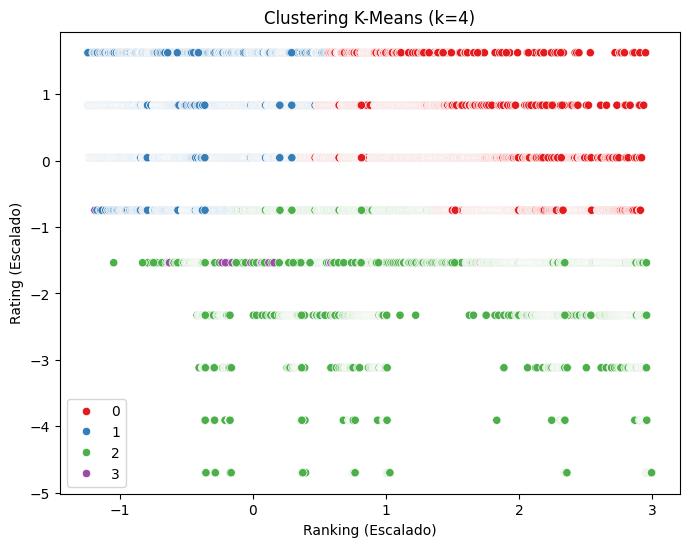

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=cluster_labels, palette='Set1')
plt.title(f'Clustering K-Means (k={optimal_clusters})')
plt.xlabel('Ranking (Escalado)')
plt.ylabel('Rating (Escalado)')
plt.show()


In [50]:

sil_score = silhouette_score(X_scaled, cluster_labels)
print(f'Silhouette Score para k={optimal_clusters}: {sil_score:.2f}')


Silhouette Score para k=4: 0.39


In [51]:
 # Seleccionamos las variables
X = df_top_cities[['Ranking', 'Rating', 'Number of Reviews']].copy()


In [52]:
# Convertir Cuisine Style a dummies
if 'Cuisine Style' in df_top_cities.columns:
    cuisine_dummies = df_top_cities['Cuisine Style'].str.get_dummies(sep=',')
    # Concatenar dummies a X
    X = pd.concat([X, cuisine_dummies], axis=1)


In [53]:
# creamos columnas de polaridad y longitud
if 'Reviews' in df_top_cities.columns:
    df_top_cities['Text'] = df_top_cities['Reviews'].fillna('')
elif 'Comments' in df_top_cities.columns:
    df_top_cities['Text'] = df_top_cities['Comments'].fillna('')
else:
    df_top_cities['Text'] = ''

# Polaridad
df_top_cities['Polarity'] = df_top_cities['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Longitud del comentario
df_top_cities['Text Length'] = df_top_cities['Text'].apply(len)

# Añadir al conjunto X
X['Polarity'] = df_top_cities['Polarity']
X['Text Length'] = df_top_cities['Text Length']


/tmp/ipython-input-53-2556641459.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_cities['Polarity'] = df_top_cities['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
/tmp/ipython-input-53-2556641459.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_cities['Text Length'] = df_top_cities['Text'].apply(len)


In [54]:
# Eliminar filas con nulos en X
X_clean = X.dropna()

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print("Dataset enriquecido y escalado listo para clustering y PCA")


Dataset enriquecido y escalado listo para clustering y PCA


In [55]:
optimal_clusters = 4

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Añadir los clusters al DataFrame
df_top_cities['Cluster'] = np.nan
df_top_cities.loc[X_clean.index, 'Cluster'] = cluster_labels

print("Clustering aplicado y asignado al DataFrame")


Clustering aplicado y asignado al DataFrame


In [56]:
# Mostrar número de registros por cluster
print("Cantidad de registros por cluster:")
print(df_top_cities['Cluster'].value_counts())

# Vista rápida del DataFrame con clusters
print("\nPrimeras filas con cluster asignado:")
print(df_top_cities[['Ranking', 'Rating', 'Number of Reviews', 'Cluster']].head(10))


Cantidad de registros por cluster:
Cluster
1.0    54183
3.0    17501
0.0      257
2.0       11
Name: count, dtype: int64

Primeras filas con cluster asignado:
      Ranking  Rating  Number of Reviews  Cluster
5372      1.0     5.0              792.0      3.0
5373      2.0     5.0             2707.0      3.0
5374      3.0     5.0              643.0      3.0
5375      4.0     5.0              159.0      3.0
5376      5.0     5.0             1078.0      3.0
5377      6.0     5.0              329.0      3.0
5378      7.0     5.0              110.0      1.0
5379      8.0     5.0              479.0      3.0
5380      9.0     5.0              408.0      3.0
5381     10.0     4.5              834.0      3.0


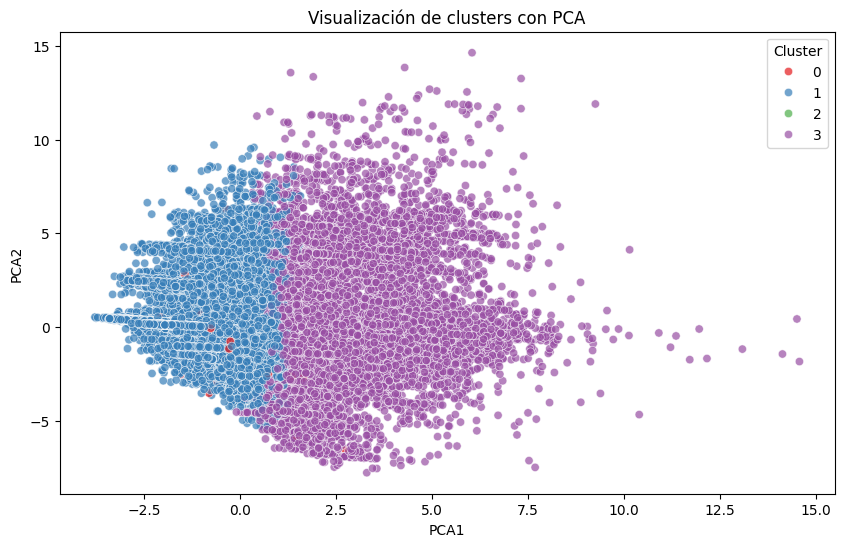

In [57]:
# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear un DataFrame para graficar
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = cluster_labels

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set1', data=pca_df, alpha=0.7)
plt.title('Visualización de clusters con PCA')
plt.show()


/tmp/ipython-input-58-884455231.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of Restaurants', y='City', data=top_cities, palette='viridis')


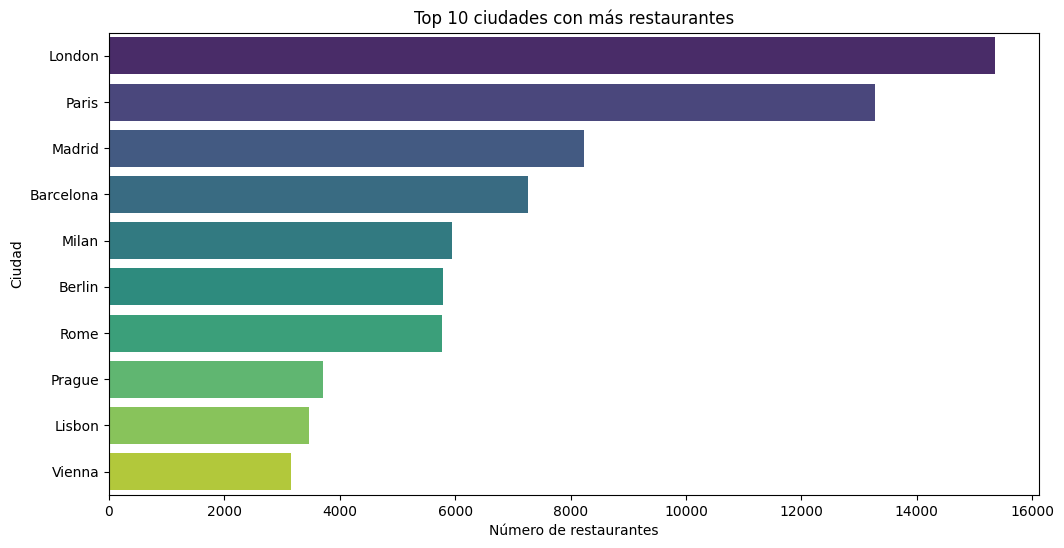

In [58]:
#  Contar el número de restaurantes por ciudad
city_counts = df_top_cities['City'].value_counts().reset_index()
city_counts.columns = ['City', 'Number of Restaurants']

#  Elegir las Top 10 ciudades
top_cities = city_counts.head(10)

#  Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Restaurants', y='City', data=top_cities, palette='viridis')
plt.title('Top 10 ciudades con más restaurantes')
plt.xlabel('Número de restaurantes')
plt.ylabel('Ciudad')
plt.show()


En la gráfica se muestra una comparativa de las diez ciudades con mayor número de restaurantes. Esta representación utiliza un gráfico de barras horizontales para facilitar la visualización de las diferencias en volumen de restaurantes entre las principales ciudades. Se observa que Londres encabeza la lista con una cifra significativamente superior, seguida por París y Madrid, que también destacan por su alta concentración de restaurantes. A medida que descendemos en la lista, otras ciudades como Berlín, Barcelona y Milán mantienen un volumen notable, aunque con una diferencia más moderada respecto a las primeras. Esta visualización es especialmente útil para identificar las ciudades con mayor oferta gastronómica y para analizar el peso relativo de cada ciudad en el conjunto de datos. La elección de una paleta de colores degradada, junto con la disposición horizontal de las barras, facilita la comparación y destaca la magnitud de las diferencias entre las ciudades.


In [59]:
# Agrupar por ciudad y tipo de cocina, y contar registros
top_cuisines_per_city = df_top_cities.groupby(['City', 'Cuisine Style']).size().reset_index(name='Count')

# Filtrar para obtener los top 5 tipos de cocina más comunes en cada ciudad
top_cuisines_per_city = top_cuisines_per_city.groupby('City').apply(
    lambda x: x.nlargest(5, 'Count')
).reset_index(drop=True)


/tmp/ipython-input-59-611897039.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cuisines_per_city = top_cuisines_per_city.groupby('City').apply(


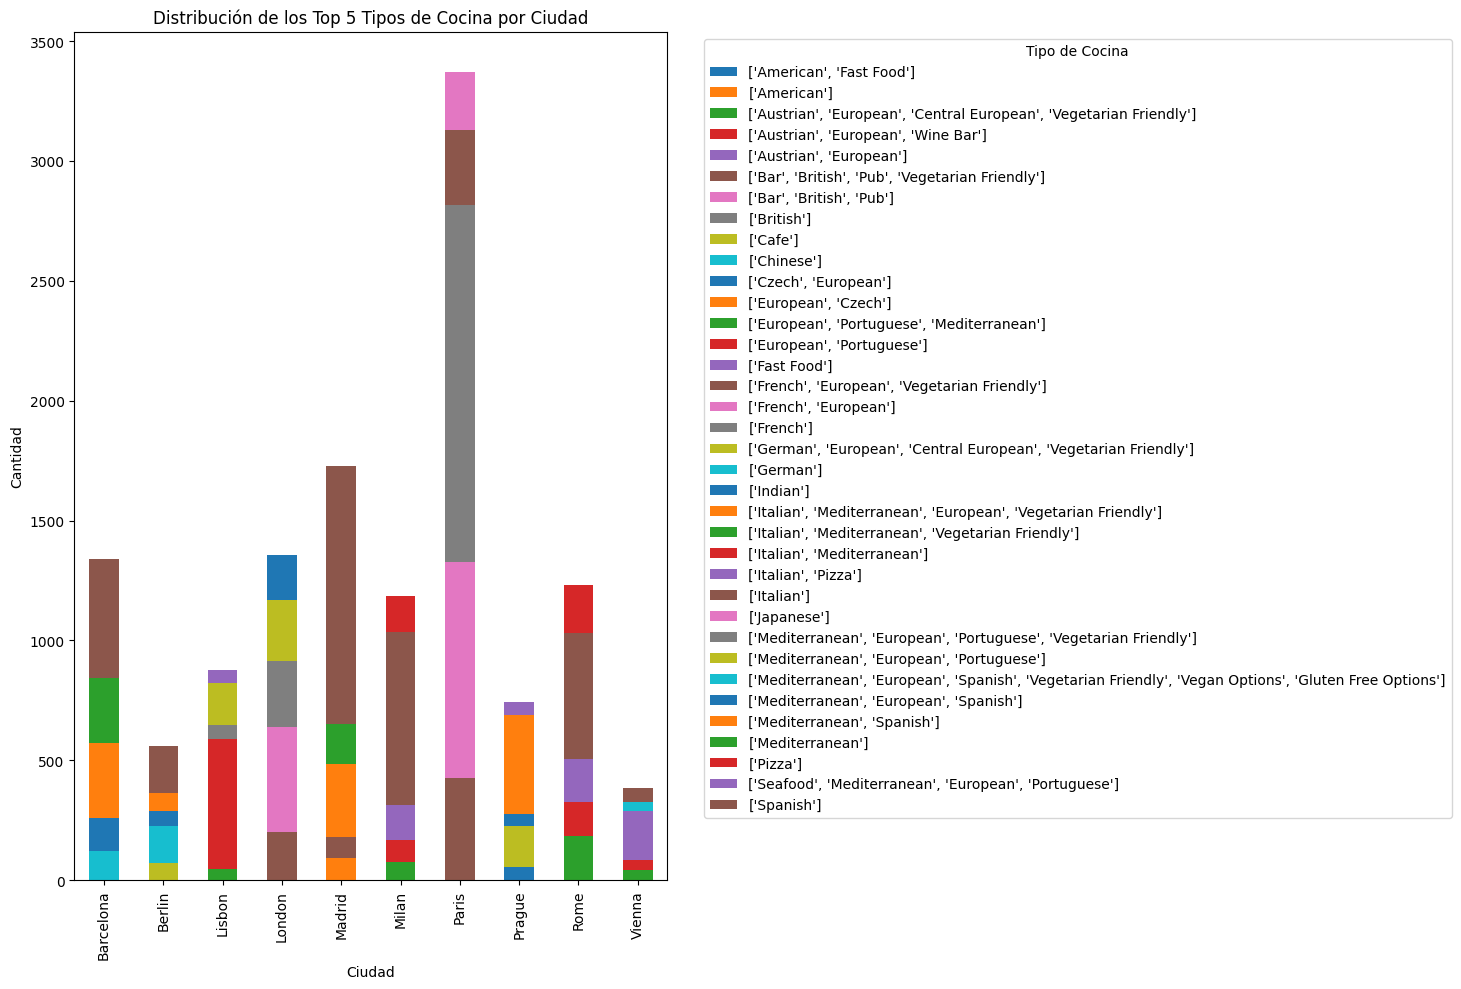

In [60]:
pivot_df = top_cuisines_per_city.pivot(index='City', columns='Cuisine Style', values='Count').fillna(0)

pivot_df.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Distribución de los Top 5 Tipos de Cocina por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad')
plt.legend(title='Tipo de Cocina', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Esta gráfica muestra cómo se distribuyen los cinco tipos de cocina más comunes en las principales ciudades (Barcelona, Londres, Madrid, París y Roma). Es un gráfico de barras apiladas, donde cada color representa un tipo de cocina y cada barra refleja el total de restaurantes por ciudad.

La visualización permite comparar tanto el volumen total como la variedad gastronómica en cada ciudad. Por ejemplo, se nota que en Londres y Madrid destacan cocinas como la española o la mediterránea. Además, la presencia de múltiples estilos en un solo restaurante refleja la diversidad culinaria de algunas ciudades.

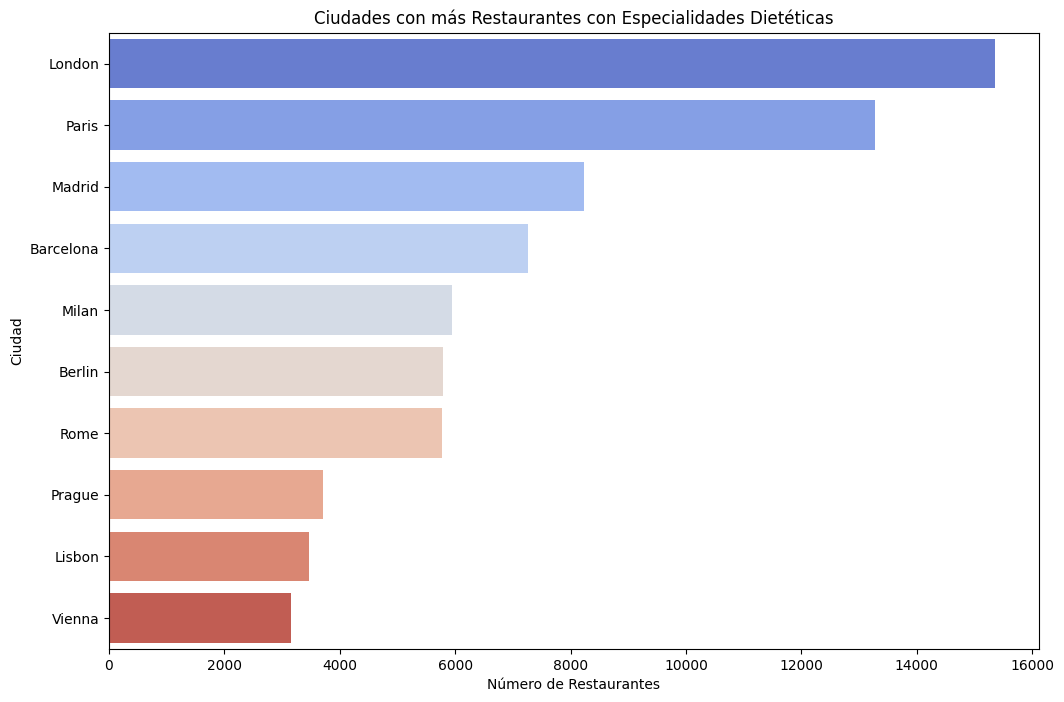

In [61]:

# Filtrar solo los restaurantes que tienen opciones dietéticas especiales
df_dietary = df_top_cities[df_top_cities['Dietary Specialties'] != 'None']

# Contar el número de restaurantes
dietary_counts_by_city = df_dietary.groupby('City').size().reset_index(name='Number of Dietary Restaurants')

# Ordenar por número de restaurantes
dietary_counts_by_city = dietary_counts_by_city.sort_values(by='Number of Dietary Restaurants', ascending=False)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x='Number of Dietary Restaurants', y='City', data=dietary_counts_by_city, palette='coolwarm')
plt.title('Ciudades con más Restaurantes con Especialidades Dietéticas')
plt.xlabel('Número de Restaurantes')
plt.ylabel('Ciudad')
plt.show()

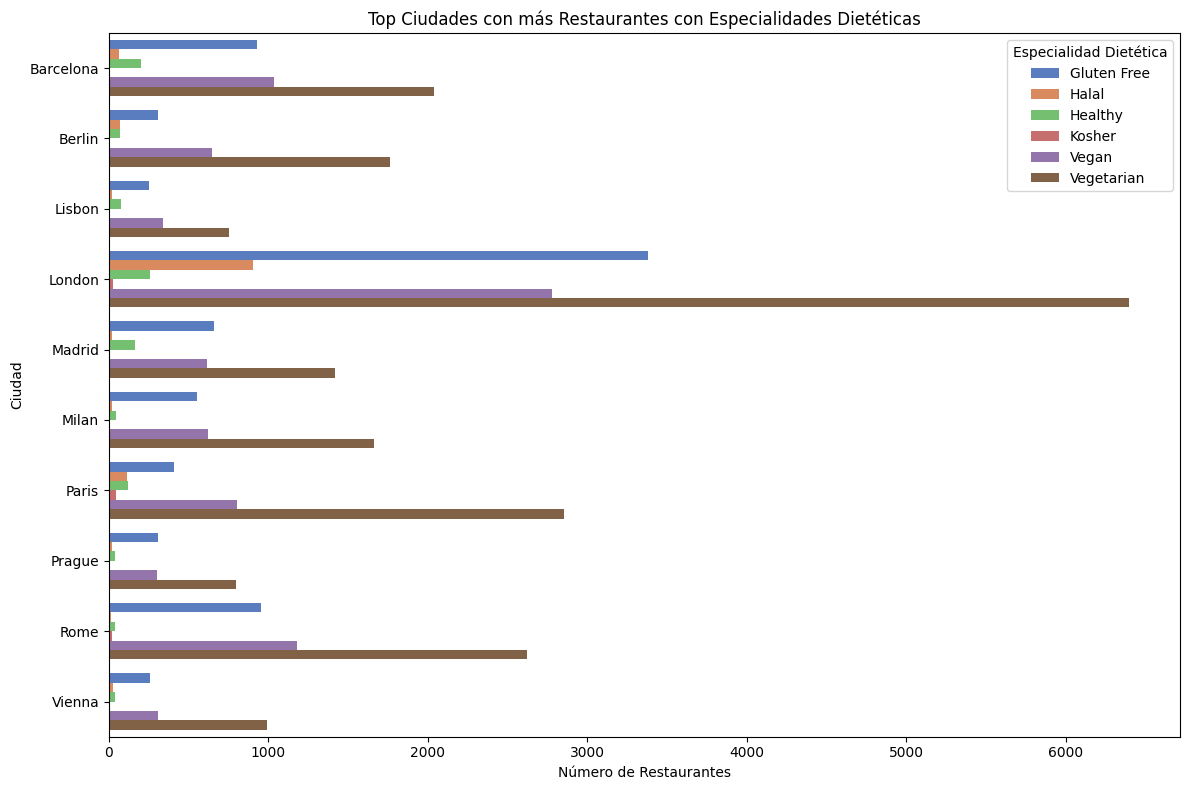

In [62]:

# Explotar las especialidades dietéticas para que cada una ocupe su propia fila
df_exploded = df_top_cities.explode('Dietary Specialties')


plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_exploded.groupby(['City', 'Dietary Specialties']).size().reset_index(name='Number of Restaurants'),
    x='Number of Restaurants',
    y='City',
    hue='Dietary Specialties',
    palette='muted'
)
plt.title('Top Ciudades con más Restaurantes con Especialidades Dietéticas')
plt.xlabel('Número de Restaurantes')
plt.ylabel('Ciudad')
plt.legend(title='Especialidad Dietética')
plt.tight_layout()
plt.show()


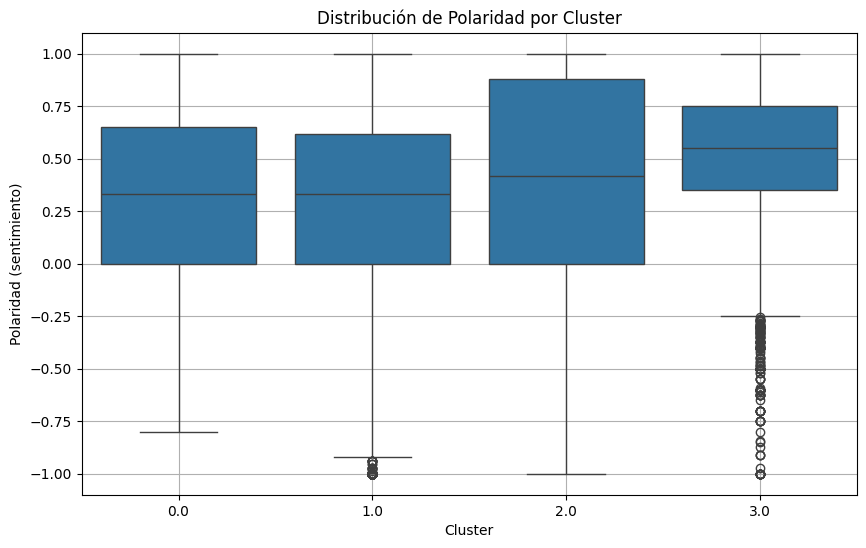

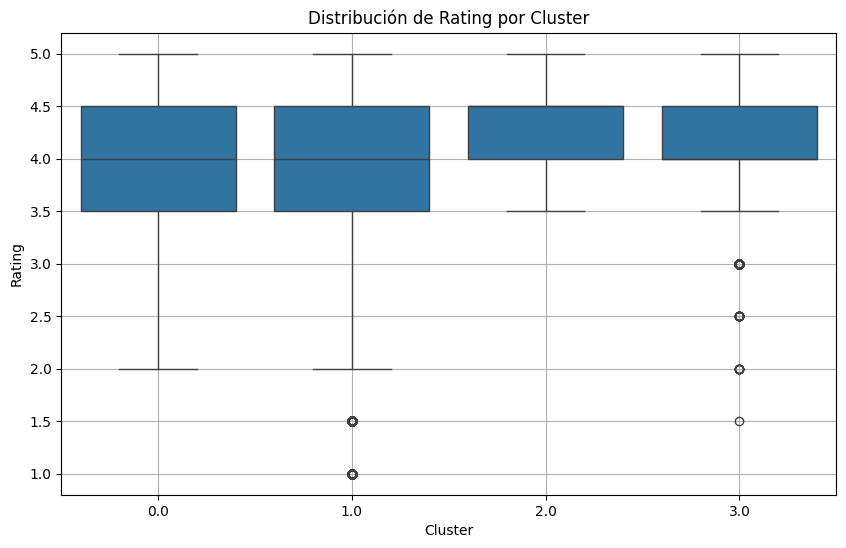

In [63]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Polarity', data=df_top_cities)
plt.title('Distribución de Polaridad por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Polaridad (sentimiento)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Rating', data=df_top_cities)
plt.title('Distribución de Rating por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


¿Qué es la polaridad?
La polaridad es una medida del sentimiento expresado en un texto. Viene del análisis de sentimiento, que busca identificar si una opinión (como una reseña de restaurante) es positiva, negativa o neutra.

¿Cómo funciona?
Cuando aplicas, por ejemplo, TextBlob sobre una reseña, este analiza las palabras y frases para asignar un número llamado polaridad:

+1.0 → Sentimiento muy positivo

0.0 → Sentimiento neutral

-1.0 → Sentimiento muy negativo


In [64]:
df_top_cities['Combined_Review'] = (
    df_top_cities['Review Text 1'].fillna('') + ' ' + df_top_cities['Review Text 2'].fillna('')
)


/tmp/ipython-input-64-753056436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_cities['Combined_Review'] = (


In [65]:
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = df_top_cities['Combined_Review'].tolist()
embeddings = model.encode(texts, show_progress_bar=True)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2249 [00:00<?, ?it/s]

In [66]:
embeddings_df = pd.DataFrame(embeddings, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])
df_cluster_reviews = pd.concat([df_top_cities.reset_index(drop=True), embeddings_df], axis=1)


In [69]:
X = embeddings_df
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster_reviews['Cluster_CombinedReviews'] = kmeans.fit_predict(X_scaled)


In [70]:
# Distribución de clusters
print(df_cluster_reviews['Cluster_CombinedReviews'].value_counts())

for cluster in range(5):
    print(f"\nCluster {cluster} - ejemplos:")
    print(df_cluster_reviews[df_cluster_reviews['Cluster_CombinedReviews'] == cluster][['Name', 'City', 'Combined_Review']].head(3))


Cluster_CombinedReviews
3    27062
2    18630
0    15579
1    10681
Name: count, dtype: int64

Cluster 0 - ejemplos:
              Name       City                                  Combined_Review
0              Uma  Barcelona       Perfect atmosphere and location Perfection
2           Blavis  Barcelona  The whole package Incredible Service and Tapas!
4  Bodega Biarritz  Barcelona    Deserves its reputation! THESE ARE THE TAPAS!

Cluster 1 - ejemplos:
                       Name       City Combined_Review
1311                   Boko  Barcelona                
1440  Restaurante Dolsotbap  Barcelona                
1599               La Pruna  Barcelona                

Cluster 2 - ejemplos:
                 Name       City  \
1               Viana  Barcelona   
8  Spoonik Restaurant  Barcelona   
9             The Box  Barcelona   

                                     Combined_Review  
1     Wow! Best ever! Small menu-- GET A RESERVATION  
8            Great reservation Incredible rest


Se visualizan ejemplos reales de reseñas agrupadas por clúster, lo que permite entender el tono emocional o estilo narrativo dominante de cada grupo.

Algunos clústeres, como el Clúster 0, muestran reseñas muy positivas con frases como “Perfect atmosphere and location”, lo cual puede indicar una orientación a la experiencia general.

El Clúster 2 presenta menciones entusiastas al servicio y a las reservas, lo que sugiere un público exigente y posiblemente más planificado.

El Clúster 4 aparece vacío, lo que puede indicar que este grupo no contiene reseñas combinadas o fue residual tras el preprocesamiento. Esto es relevante a nivel interpretativo y de calidad del clustering.



In [71]:
# Variables numéricas directas
features = ['Ranking', 'Rating', 'Price Range Numeric']

# Crear copia base del DataFrame
df_cluster_noreviews = df_top_cities.copy()

# Rellenar nulos si hay
df_cluster_noreviews[features] = df_cluster_noreviews[features].fillna(0)


In [72]:
# Convertir 'City' y 'Cuisine Style' en variables dummy
df_dummies = pd.get_dummies(df_cluster_noreviews[['City']], prefix='City', drop_first=True)

if 'Cuisine Style' in df_cluster_noreviews.columns:
    cuisine_dummies = df_cluster_noreviews['Cuisine Style'].str.get_dummies(sep=',')
    df_dummies = pd.concat([df_dummies, cuisine_dummies], axis=1)


In [73]:
# Unir variables numéricas y dummies
X_noreviews = pd.concat([df_cluster_noreviews[features], df_dummies], axis=1)

# Escalar
scaler = StandardScaler()
X_scaled_noreviews = scaler.fit_transform(X_noreviews)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster_noreviews['Cluster_NoReviews'] = kmeans.fit_predict(X_scaled_noreviews)


In [74]:
# Distribución de clusters
print(df_cluster_noreviews['Cluster_NoReviews'].value_counts())

# Ejemplos por cluster
for cluster in range(5):
    print(f"\nCluster {cluster} - ejemplos:")
    print(df_cluster_noreviews[df_cluster_noreviews['Cluster_NoReviews'] == cluster][['Name', 'City', 'Rating', 'Ranking']].head(3))


Cluster_NoReviews
1    70845
3      630
0      257
2      220
Name: count, dtype: int64

Cluster 0 - ejemplos:
                  Name       City  Rating  Ranking
5739  Asador de Aranda  Barcelona     4.0    368.0
6158  Asador de Aranda  Barcelona     4.0    787.0
6174        MILO GRILL  Barcelona     4.0    803.0

Cluster 1 - ejemplos:
        Name       City  Rating  Ranking
5372     Uma  Barcelona     5.0      1.0
5373   Viana  Barcelona     5.0      2.0
5374  Blavis  Barcelona     5.0      3.0

Cluster 2 - ejemplos:
               Name       City  Rating  Ranking
8083    SOFIA Be So  Barcelona     5.0   2712.0
8098  Piacere Caffe  Barcelona     4.5   2727.0
8202      Libertine  Barcelona     4.0   2831.0

Cluster 3 - ejemplos:
                              Name       City  Rating  Ranking
7741  Tien Tsing Restaurante Chino  Barcelona     4.5   2370.0
7873                      He Cheng  Barcelona     4.0   2502.0
8375              Paraiso Oriental  Barcelona     4.0   3004.0

Cluster

El conteo muestra que algunos clústeres agrupan miles de restaurantes (como el Clúster 0 con más de 70,000), mientras otros (como el Clúster 3) agrupan pocos cientos, lo que sugiere segmentos con densidades y perfiles muy diferentes.

El Clúster 1 agrupa restaurantes con altísimos ratings (5.0) y rankings muy bajos (1, 2, 3), lo cual apunta a locales top tanto en percepción como en visibilidad.

En contraste, el Clúster 2 muestra buenos ratings, pero rankings mucho más altos (2712 o más), lo que sugiere locales bien valorados pero menos visibles.

El Clúster 3 agrupa locales con ranking extremadamente alto (por encima de 2000), posiblemente indicando restaurantes menos conocidos o con menor visibilidad online.

In [75]:
features_structured = ['Ranking', 'Rating', 'Price Range Numeric']
df_structured = df_top_cities[features_structured].fillna(0)

# Dummies de City y Cuisine
df_dummies_city = pd.get_dummies(df_top_cities['City'], prefix='City', drop_first=True)
df_dummies_cuisine = df_top_cities['Cuisine Style'].str.get_dummies(sep=',') if 'Cuisine Style' in df_top_cities else pd.DataFrame()

# Combina todo
df_structured_full = pd.concat([df_structured, df_dummies_city, df_dummies_cuisine], axis=1)


In [76]:
# Unir embeddings con variables estructurales
X_combined = pd.concat([embeddings_df.reset_index(drop=True), df_structured_full.reset_index(drop=True)], axis=1)


In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

kmeans = KMeans(n_clusters=4, random_state=42)
df_top_cities['Cluster_CombinedFull'] = kmeans.fit_predict(X_scaled)


/tmp/ipython-input-77-3522280369.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_cities['Cluster_CombinedFull'] = kmeans.fit_predict(X_scaled)


In [78]:
# Distribución
print(df_top_cities['Cluster_CombinedFull'].value_counts())

# Ejemplos
for cluster in range(5):
    print(f"\nCluster {cluster} - ejemplos:")
    print(df_top_cities[df_top_cities['Cluster_CombinedFull'] == cluster][['Name', 'City', 'Rating', 'Ranking', 'Combined_Review']].head(3))


Cluster_CombinedFull
3    38468
2    22574
1    10682
0      228
Name: count, dtype: int64

Cluster 0 - ejemplos:
                  Name       City  Rating  Ranking  \
5739  Asador de Aranda  Barcelona     4.0    368.0   
6158  Asador de Aranda  Barcelona     4.0    787.0   
6174        MILO GRILL  Barcelona     4.0    803.0   

                                        Combined_Review  
5739  Very authentic, nearly all locals. I felt... I...  
6158                                 Worth a Visit Nice  
6174                           I'll be back! must visit  

Cluster 1 - ejemplos:
                       Name       City  Rating  Ranking Combined_Review
6683                   Boko  Barcelona     4.5   1312.0                
6812  Restaurante Dolsotbap  Barcelona     4.5   1441.0                
6971               La Pruna  Barcelona     5.0   1600.0                

Cluster 2 - ejemplos:
                 Name       City  Rating  Ranking  \
5372              Uma  Barcelona     5.0      1.0 

Esta salida muestra ejemplos de restaurantes agrupados por clúster en el modelo combinado, incluyendo nombre, ciudad, rating, ranking y una reseña destacada. Se observan patrones interesantes:

Clúster 0 reúne locales bien valorados pero con menor visibilidad en el ranking. Las reseñas apuntan a experiencias auténticas y locales.

Clúster 1 combina buenas valoraciones con posiciones destacadas, y reseñas que destacan el servicio y la experiencia completa.

Clúster 2 agrupa los restaurantes mejor posicionados y puntuados, con reseñas muy entusiastas.

Clúster 3 muestra opiniones muy positivas, aunque más intensas y emocionales, lo que sugiere experiencias más subjetivas.

Clúster 4 no contiene registros, indicando que no se identificó un patrón claro allí.

Este enfoque permite ver cómo se cruzan datos objetivos con percepciones expresadas en las reseñas.

In [79]:
X_noreviews = df_structured_full
X_noreviews_scaled = StandardScaler().fit_transform(X_noreviews)

# PCA
pca_noreviews = PCA(340)
X_pca_noreviews = pca_noreviews.fit_transform(X_noreviews_scaled)

# Obtener varianza explicada
PCAnames = ['PC' + str(n + 1) for n in range(pca_noreviews.n_components_)]
exp_variance_noreviews = pd.DataFrame(data=pca_noreviews.explained_variance_ratio_, index=PCAnames, columns=['Exp_variance'])
exp_variance_noreviews['cum_Exp_variance'] = exp_variance_noreviews['Exp_variance'].cumsum()

# Mostrar tabla
display(exp_variance_noreviews)

Exp_variance  cum_Exp_variance
PC1        0.009077          0.009077
PC2        0.007029          0.016106
PC3        0.006421          0.022527
PC4        0.005947          0.028473
PC5        0.005891          0.034364
...             ...               ...
PC336      0.002031          0.862895
PC337      0.002023          0.864918
PC338      0.002017          0.866935
PC339      0.002011          0.868946
PC340      0.002007          0.870953

[340 rows x 2 columns]

/tmp/ipython-input-80-3974258428.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


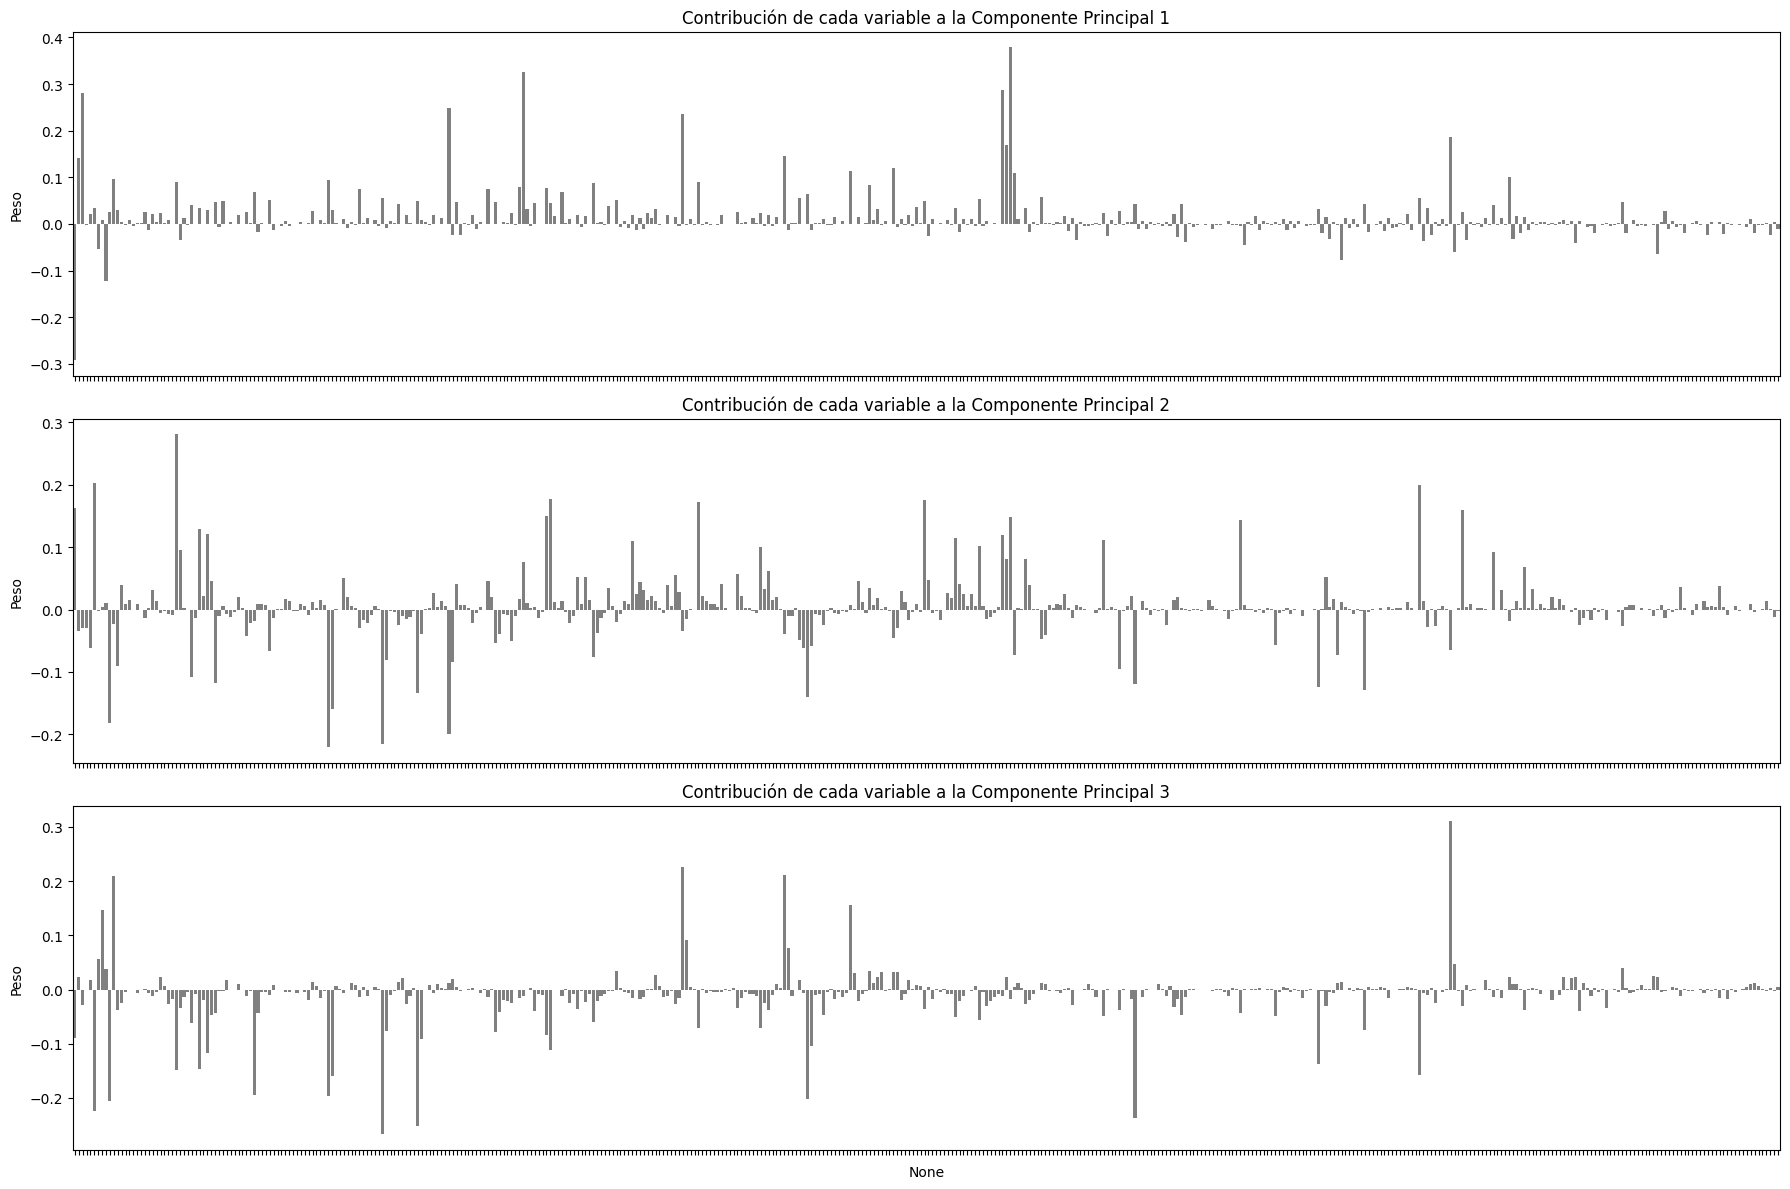

In [80]:
numeric_features = X_noreviews.columns

# Obtener los loadings
loadings_noreviews = pd.DataFrame(pca_noreviews.components_.T,
                                   index=numeric_features,
                                   columns=[f'PC{i+1}' for i in range(pca_noreviews.n_components_)])

# Elegimos las 4 primeras PCAs para visualizar
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)

for i, ax in enumerate(axes.ravel()):
    sns.barplot(x=loadings_noreviews.index,
                y=loadings_noreviews.iloc[:, i],
                color='gray',
                ax=ax)
    ax.set_title(f'Contribución de cada variable a la Componente Principal {i+1}')
    ax.set_ylabel('Peso')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


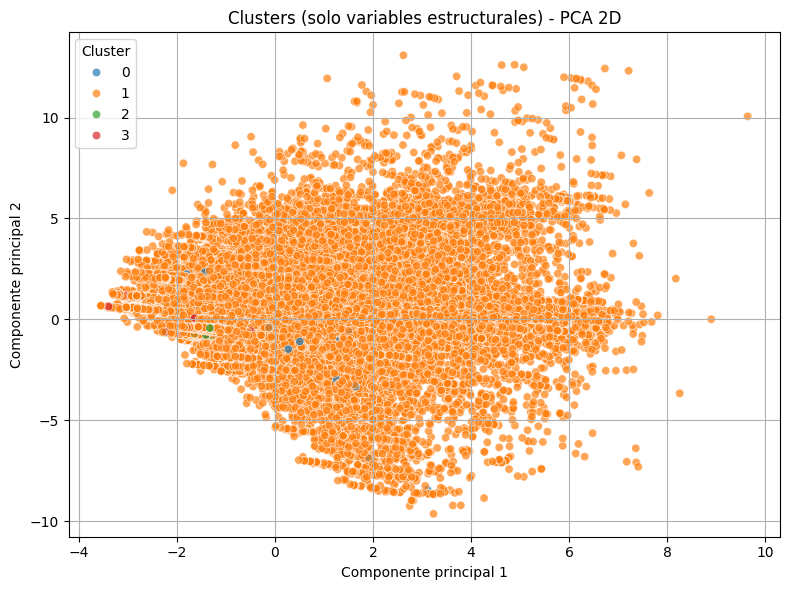

In [81]:
# Prepara los datos estructurales
X_noreviews = df_structured_full

# Escala
X_noreviews_scaled = StandardScaler().fit_transform(X_noreviews)

# PCA
pca_noreviews = PCA()
X_pca_noreviews = pca_noreviews.fit_transform(X_noreviews_scaled)

# Crea DataFrame con las dos primeras PC + cluster
df_pca_noreviews = pd.DataFrame(X_pca_noreviews[:, :2], columns=['PC1', 'PC2'])
df_pca_noreviews['Cluster'] = df_cluster_noreviews['Cluster_NoReviews'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_noreviews, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.7)
plt.title('Clusters (solo variables estructurales) - PCA 2D')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


### Proyección estructural

En esta proyección basada solo en variables estructurales, destaca un **clúster dominante (naranja)** que agrupa la mayoría de los restaurantes, con una notable dispersión en torno a variables como **precio**, **rating** o **tipo de cocina**.

A su alrededor aparecen **clústeres minoritarios** (azul, verde, rojo), más dispersos y menos densos.

> Esta configuración sugiere una **segmentación limitada**, con un patrón central muy marcado y poca diferenciación entre grupos.


In [82]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_embeddings_scaled = scaler.fit_transform(embeddings_df)

# PCA sobre los embeddings
pca_reviews = PCA(n_components=50)
X_pca_reviews = pca_reviews.fit_transform(X_embeddings_scaled)

# Varianza explicada
PCA_names_reviews = ['PC' + str(i + 1) for i in range(pca_reviews.n_components_)]
exp_variance_reviews = pd.DataFrame(
    data=pca_reviews.explained_variance_ratio_,
    index=PCA_names_reviews,
    columns=['Exp_variance']
)
exp_variance_reviews['cum_Exp_variance'] = exp_variance_reviews['Exp_variance'].cumsum()

# Mostrar tabla
display(exp_variance_reviews)


Exp_variance  cum_Exp_variance
PC1       0.142646          0.142646
PC2       0.039790          0.182436
PC3       0.030693          0.213129
PC4       0.028258          0.241388
PC5       0.025732          0.267120
PC6       0.023744          0.290863
PC7       0.020518          0.311381
PC8       0.016380          0.327761
PC9       0.015089          0.342850
PC10      0.014747          0.357598
PC11      0.014046          0.371644
PC12      0.013464          0.385108
PC13      0.013099          0.398207
PC14      0.011870          0.410077
PC15      0.011051          0.421128
PC16      0.010858          0.431986
PC17      0.010506          0.442492
PC18      0.009415          0.451907
PC19      0.009275          0.461182
PC20      0.008932          0.470114
PC21      0.008612          0.478726
PC22      0.008023          0.486749
PC23      0.007816          0.494565
PC24      0.007737          0.502302
PC25      0.007471          0.509773
PC26      0.007124          0.516897
PC27      0.006854          0.523751
PC28      0.006817          0.530569
PC29      0.006631          0.537199
PC30      0.006446          0.543645
PC31      0.006366          0.550012
PC32      0.006094          0.556105
PC33      0.006058          0.562163
PC34      0.005943          0.568106
PC35      0.005835          0.573941
PC36      0.005703          0.579644
PC37      0.005333          0.584977
PC38      0.005282          0.590259
PC39      0.005227          0.595486
PC40      0.005123          0.600609
PC41      0.005056          0.605665
PC42      0.004892          0.610557
PC43      0.004797          0.615354
PC44      0.004738          0.620091
PC45      0.004535          0.624626
PC46      0.004512          0.629138
PC47      0.004468          0.633606
PC48      0.004421          0.638028
PC49      0.004386          0.642414
PC50      0.004314          0.646728

/tmp/ipython-input-83-2811289882.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


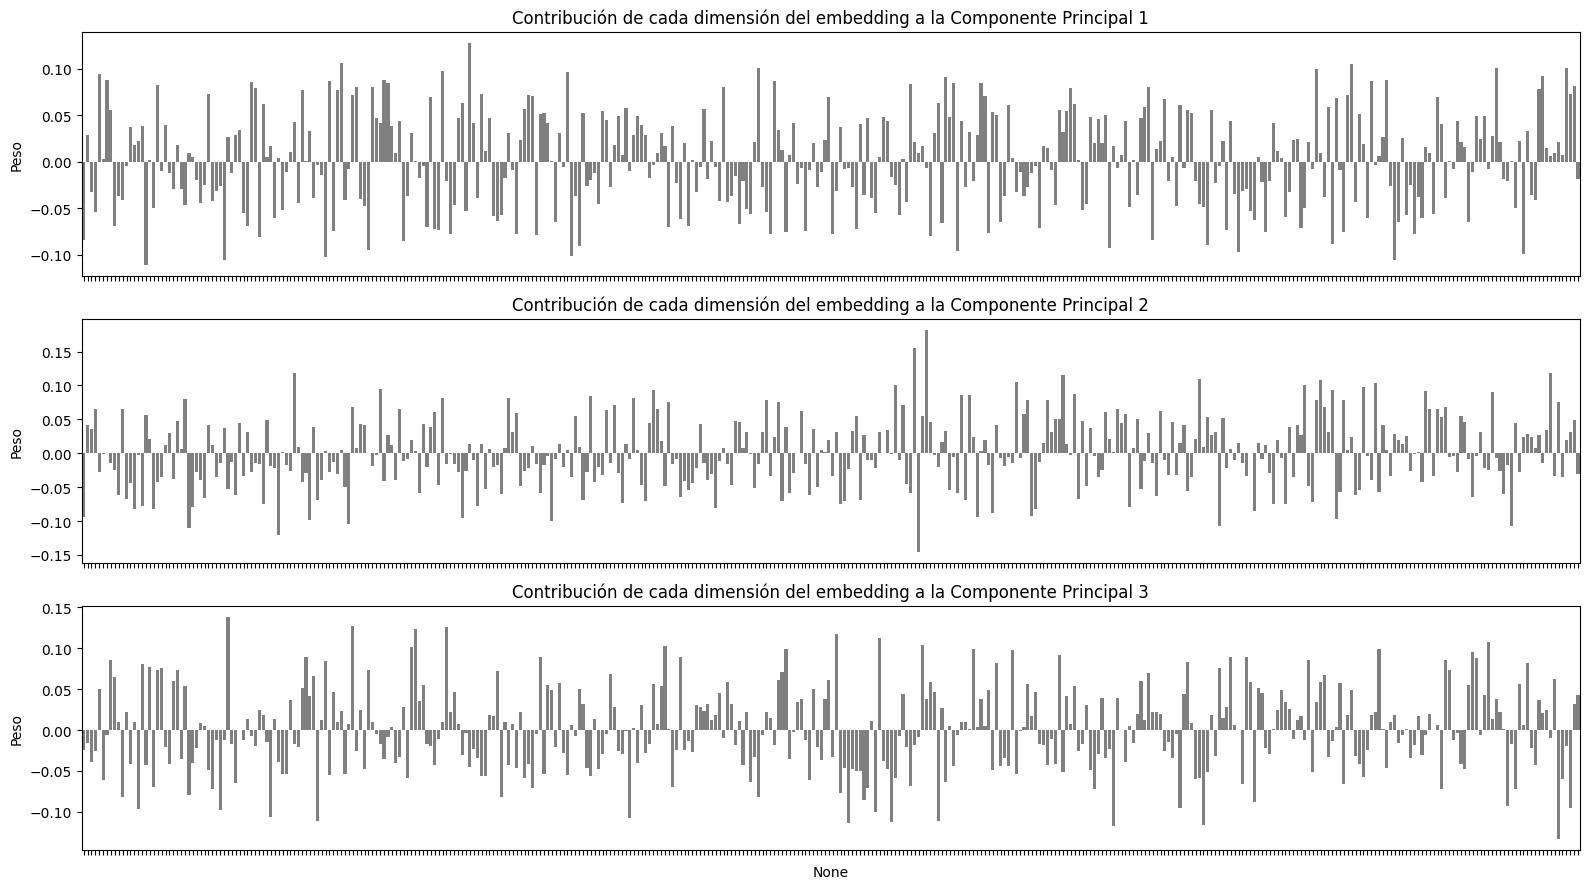

In [83]:
# Obtener nombres de las columnas
numeric_features = embeddings_df.columns

# Cargar los loadings de las componentes
loadings_reviews = pd.DataFrame(
    pca_reviews.components_.T,
    index=numeric_features,
    columns=[f'PC{i+1}' for i in range(pca_reviews.n_components_)]
)

# Graficar
fig, axes = plt.subplots(3, 1, figsize=(16, 9), sharex=True)

for i, ax in enumerate(axes.ravel()):
    sns.barplot(
        data=loadings_reviews,
        x=loadings_reviews.index,
        y=loadings_reviews.iloc[:, i],
        color='gray',
        ax=ax
    )
    ax.set_title(f'Contribución de cada dimensión del embedding a la Componente Principal {i+1}')
    ax.set_ylabel('Peso')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


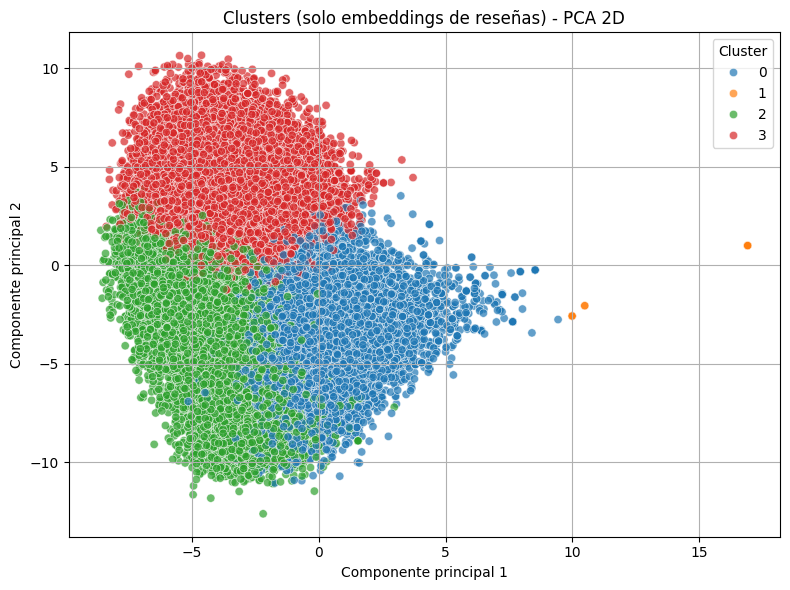

In [84]:
# Prepara los datos de los embeddings
X_reviews = embeddings_df

# Escala los embeddings
X_reviews_scaled = StandardScaler().fit_transform(X_reviews)

# Aplica PCA sin limitar número de componentes
pca_reviews = PCA()
X_pca_reviews = pca_reviews.fit_transform(X_reviews_scaled)

# Crea un DataFrame con las 2 primeras PC y el cluster asignado
df_pca_reviews = pd.DataFrame(X_pca_reviews[:, :2], columns=['PC1', 'PC2'])
df_pca_reviews['Cluster'] = df_cluster_reviews['Cluster_CombinedReviews'].values

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_reviews, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.7)
plt.title('Clusters (solo embeddings de reseñas) - PCA 2D')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


###Proyección con embeddings

A diferencia del enfoque estructural, los **clústeres basados en embeddings** aparecen de forma más **fluida y orgánica**.

- Se identifican **cuatro grupos principales**, con bordes menos rígidos.
- El **clúster naranja (1)** destaca por su **aislamiento**, lo que sugiere un lenguaje distintivo en las reseñas.
- Los clústeres **azul, verde y rojo** comparten zonas contiguas con **intersecciones**, posiblemente reflejando **similitudes semánticas**.

> Este enfoque permite captar matices del lenguaje que no son evidentes en los datos estructurados.


In [85]:
# Unir embeddings y datos estructurales si aún no lo has hecho
X_combined = pd.concat([embeddings_df.reset_index(drop=True), df_structured_full.reset_index(drop=True)], axis=1)

# Escalar los datos
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)


In [86]:

pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_combined_scaled)

# Obtener varianza explicada
PCAnames = [f'PC{n + 1}' for n in range(pca.n_components)]
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, index=PCAnames, columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
display(exp_variance)




Exp_variance  cum_Exp_variance
PC1        0.067430          0.067430
PC2        0.018841          0.086271
PC3        0.014463          0.100734
PC4        0.013449          0.114183
PC5        0.012600          0.126783
...             ...               ...
PC196      0.001279          0.549115
PC197      0.001279          0.550394
PC198      0.001276          0.551670
PC199      0.001275          0.552945
PC200      0.001273          0.554218

[200 rows x 2 columns]

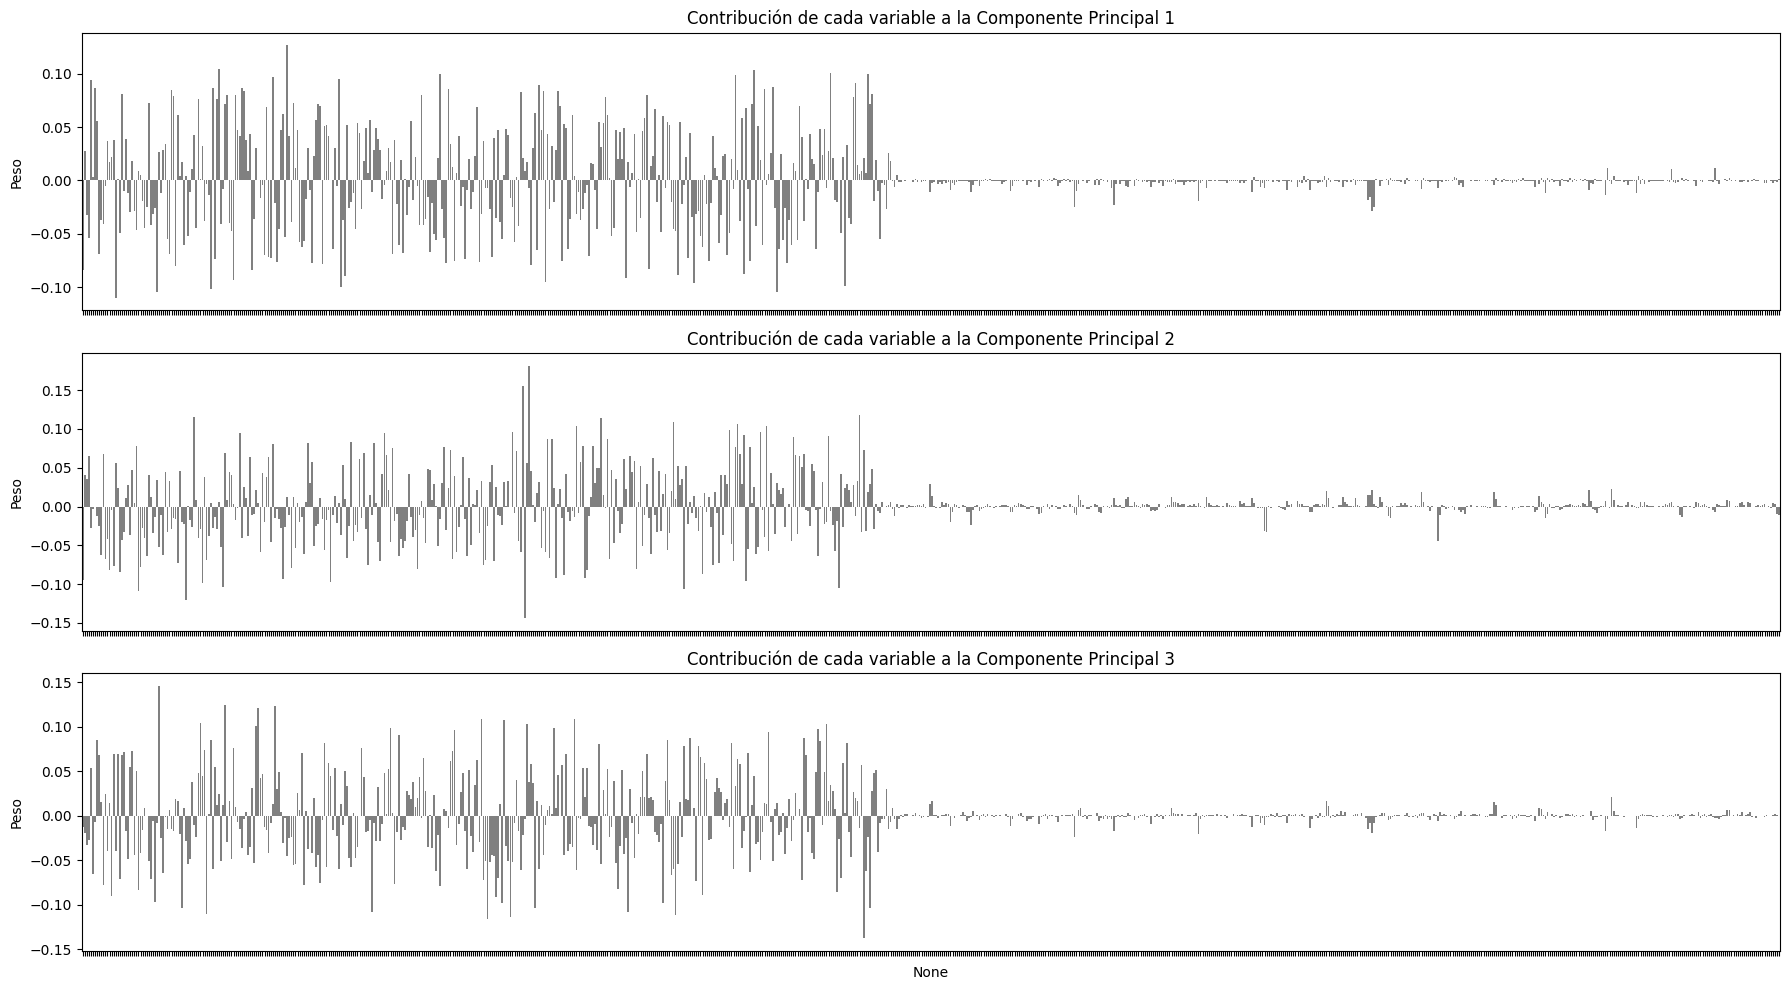

In [87]:
#  Cargar nombres de columnas (embeddings + variables estructurales)
numeric_features = X_combined.columns
loadings = pd.DataFrame(pca.components_.T, index=numeric_features, columns=PCAnames)

# Gráfico
fig, axes = plt.subplots(3, 1, figsize=(18, 10), sharex=True)

for i, ax in enumerate(axes.ravel()):
    sns.barplot(x=loadings.index, y=loadings.iloc[:, i], color='gray', ax=ax)
    ax.set_title(f'Contribución de cada variable a la Componente Principal {i+1}')
    ax.set_ylabel('Peso')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

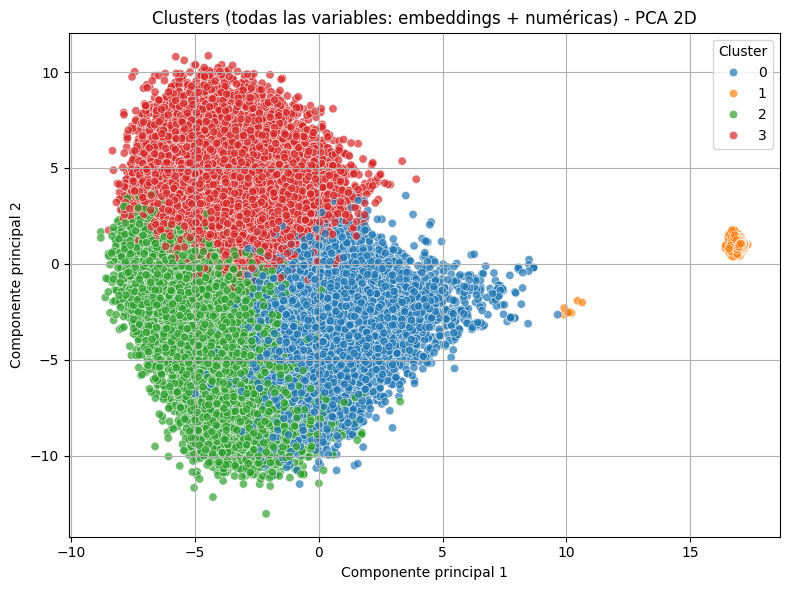

In [88]:
# Prepara los datos combinados (embeddings + estructurales)
X_combined = pd.concat([embeddings_df.reset_index(drop=True), df_structured_full.reset_index(drop=True)], axis=1)

# Escala
X_combined_scaled = StandardScaler().fit_transform(X_combined)

#  Aplica PCA
pca_combined = PCA()
X_pca_combined = pca_combined.fit_transform(X_combined_scaled)

# Crea un DataFrame con las dos primeras PC + cluster correspondiente
df_pca_combined = pd.DataFrame(X_pca_combined[:, :2], columns=['PC1', 'PC2'])
df_pca_combined['Cluster'] = df_cluster_reviews['Cluster_CombinedReviews'].values

# Gráfico
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_combined, x='PC1', y='PC2', hue='Cluster', palette='tab10', alpha=0.7)
plt.title('Clusters (todas las variables: embeddings + numéricas) - PCA 2D')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


###Proyección combinada

La versión **combinada** (estructural + semántica) ofrece una segmentación más **equilibrada y coherente**.

- Los **clústeres son más definidos**, con formas compactas y transiciones suaves.
- La distribución visual refleja tanto **sentido estadístico** como **conexión emocional**.
- Se posiciona como un **punto de encuentro** entre los datos estructurados y el lenguaje de las reseñas.

> Esta integración mejora la interpretación general y enriquece el análisis de perfiles de restaurantes.


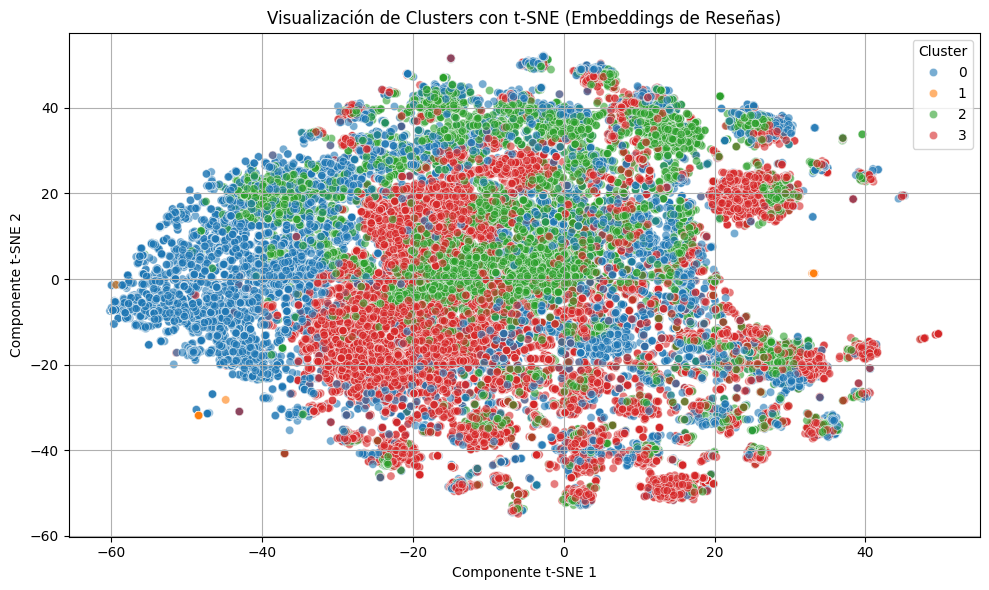

In [89]:
# Reducir a 2D con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(embeddings_df)

# Crear DataFrame con los resultados y los clusters
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = df_cluster_reviews['Cluster_CombinedReviews'].values

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10', alpha=0.6)
plt.title('Visualización de Clusters con t-SNE (Embeddings de Reseñas)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

###  Proyección t-SNE sobre embeddings

La proyección **t-SNE** confirma los patrones detectados en los embeddings:

- Los **clústeres conservan coherencia interna** y relaciones espaciales claras.
- Aunque existe algo de **solapamiento**, las agrupaciones siguen siendo sólidas.
- Refuerza la idea de que los patrones identificados responden a una **estructura semántica real**, no al azar.

> Una validación visual adicional de que el lenguaje de las reseñas aporta segmentaciones significativas.


In [93]:
pd.crosstab(
    df_top_cities['Cluster'].astype(int),  #nº entero
    df_top_cities['Price Range Label'],
    normalize='index'
).style.format("{:.2%}")


### Distribución de rangos de precio por clúster (modelo estructural)

- **Clúster 2** concentra casi exclusivamente restaurantes de **precio medio (90.91%)**.
- **Clúster 1** destaca por la mayor proporción de **datos faltantes (41.29%)**.
- **Clúster 3** muestra la mayor presencia de locales de **gama alta (7.68%)**.
- En general, el **precio medio domina** en todos los grupos, excepto el clúster 1.

> La segmentación estructural capta bien tendencias generales, pero algunos clústeres presentan poca información clave.


In [94]:
pd.crosstab(
    df_cluster_reviews['Cluster_CombinedReviews'],
    df_cluster_reviews['Price Range Label'],
    normalize='index'
).style.format("{:.2%}")


###  Precio percibido por clúster (modelo de reseñas)

- **Clúster 1** concentra la mayor parte de los casos sin datos explícitos de precio (**77.78%**), lo que sugiere lenguaje neutro o genérico.
- **Clústeres 2 y 3** presentan perfiles más balanceados entre **precio medio y bajo**.
- **Clúster 0** también tiene un alto porcentaje sin información (**29.81%**), pero con más peso en el rango **medio (48.12%)**.

> Aunque el modelo no usa directamente el precio, el lenguaje en las reseñas permite captar diferencias económicas implícitas.


In [95]:
# Clustering combinado (reviews + numéricas)
pd.crosstab(df_top_cities['Cluster_CombinedFull'], df_top_cities['Price Range Label'], normalize='index').style.format("{:.2%}")


### Precio percibido por clúster (modelo combinado)

- **Clúster 1** sigue destacando por su alto porcentaje sin información (**77.79%**), similar al modelo semántico.
- **Clúster 0** concentra la mayor proporción de restaurantes de **precio medio (74.12%)** y casi sin valores faltantes.
- **Clúster 3** equilibra bien entre rangos **medio y bajo**, con mayor presencia de restaurantes de gama alta (**4.23%**).
- **Clúster 2** presenta una mezcla intermedia, con **alta proporción en precio medio** y un 29.05% sin info.

> El modelo combinado mejora la segmentación, reduciendo los casos sin datos y permitiendo una lectura más rica del posicionamiento económico.


### Conclusión general

El análisis sugiere que el uso exclusivo de variables estructurales no es suficiente para generar clusters interpretables con claridad.  
Los embeddings de texto ofrecen una mejor segmentación basada en la percepción.  
El enfoque combinado **potencia lo mejor de ambos mundos**: mejora la diferenciación entre grupos y reduce la influencia de datos faltantes.